# Photo-to-map image comparison using fuzzy sets

## Preprocessing

### Segment buildings from map

Eliminate trees and lawns

In [28]:
def eliminate_green(im_base, plot=True):
    # Channels: Blue, Green, Red
    blue_channel = np.array(im_base[:,:,0])
    blue_channel[blue_channel == 0] = 1
    green_channel = np.array(im_base[:,:,1])
    green_channel[green_channel == 0] = 1
    red_channel = np.array(im_base[:,:,2])
    red_channel[red_channel == 0] = 1

    green_areas1 = np.where(green_channel / red_channel >= 1.1, np.ones(np.shape(green_channel)), np.zeros(np.shape(green_channel)))
    green_areas2 = np.where(green_channel / blue_channel >= 1.1, np.ones(np.shape(green_channel)), np.zeros(np.shape(green_channel)))
    green_areas = np.zeros(np.shape(green_areas1), dtype=int)
    for i in range(np.shape(green_areas1)[0]):
          for j in range(np.shape(green_areas1)[1]):
            if green_areas1[i, j] == green_areas2[i, j] == 1:
                  green_areas[i, j] = 1

    if plot:
        plt.imshow(green_areas, cmap='gray')
        plt.title("Green areas")
        plt.show()

    im_grey = np.array(cv2.cvtColor(im_base, cv2.COLOR_BGR2GRAY))
    im_grey = im_grey / 255
    for i in range(np.shape(im_grey)[0]):
          for j in range(np.shape(im_grey)[1]):
            if green_areas[i, j]:
                  im_grey[i, j] = 0


    if plot:
        plt.imshow(im_grey, cmap='gray')
        plt.title("Image without green areas")
        plt.show()
    
    return im_grey

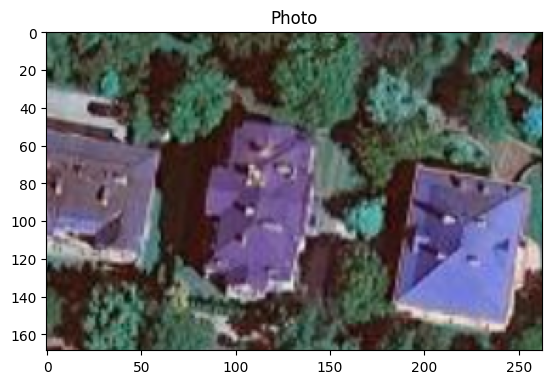

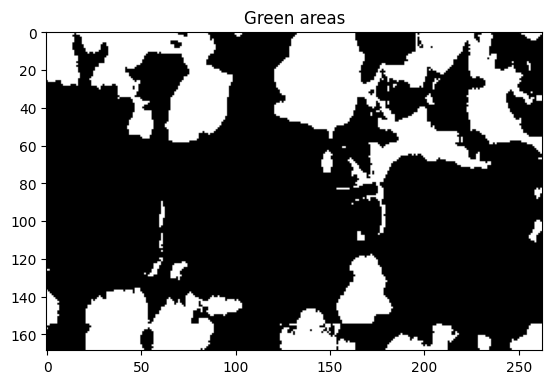

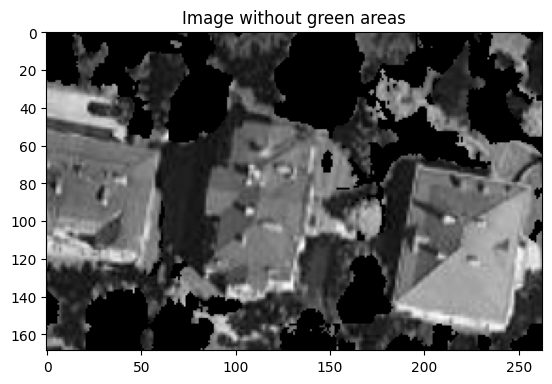

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("map1.png")
plt.imshow(img)
plt.title("Photo")
plt.show()
img = eliminate_green(img)

Segmentation

In [30]:
def segment_buildings(im_grey, threshold=70, kernel_size=15, plot=True):
    cv2.imwrite('tmp.png', im_grey*255)
    img = cv2.imread('tmp.png', 0)
    img = cv2.medianBlur(img,5)
    ret, img_bin = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    
    if plot:
        plt.imshow(img_bin, cmap='gray')
        plt.title("Binary image")
        plt.show()

#     kernel_size = 15 
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)
    if plot:
        plt.imshow(opening, cmap="gray")
        plt.title("Opening the image")
        plt.show()
        
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    if plot:
        plt.imshow(closing, cmap="gray")
        plt.title("Closing the image")
        plt.show()

    cv2.imwrite('result.png', closing)
    return closing

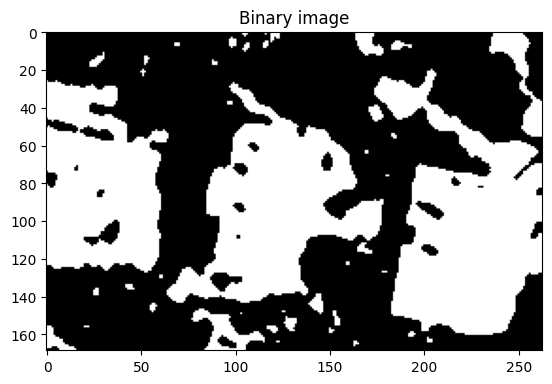

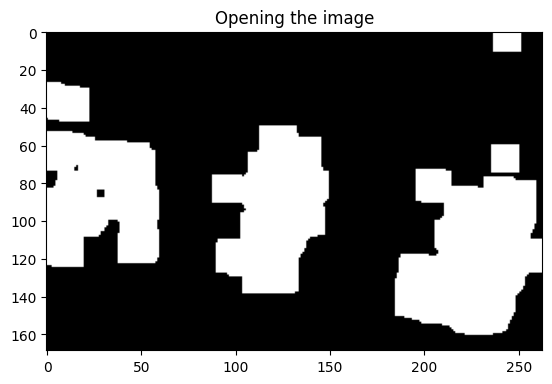

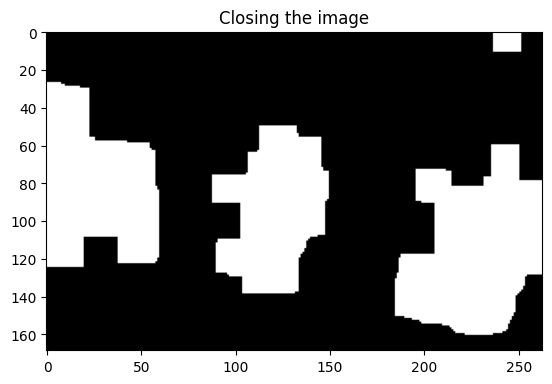

In [31]:
img = segment_buildings(img)

### Create graph

In [32]:
import math

def distance(x1, y1, x2, y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

# Represent edges as a matrix and nodes as indexes with centroids
def create_graph(centroids_list):
    nodes = np.zeros(np.shape(centroids_list))
    edges = np.zeros((len(centroids_list), len(centroids_list)))
    for id1 in range(len(centroids_list)):
        nodes[id1] = centroids_list[id1]
        for id2 in range(len(centroids_list)):
            dist = distance(centroids_list[id1][0], centroids_list[id1][1], centroids_list[id2][0], centroids_list[id2][1])
            edges[id1, id2] = dist
    return nodes, edges    

In [33]:
def show_centers(image, nodes):
    centers_x = [centr[0] for centr in nodes]
    centers_y = [centr[1] for centr in nodes]
    plt.imshow(image, cmap="gray")
    plt.plot(centers_x, centers_y, 'r.')
    for i in range(len(nodes)):
        plt.text(nodes[i, 0], nodes[i, 1], i, color='r')
#     plt.xlim([0, image.shape[1]])
#     plt.ylim([0, image.shape[0]])
    plt.title("Nodes of the graph representing the image")
    plt.show()

In [34]:
def image_to_graph(img, plot=True):
    analysis = cv2.connectedComponentsWithStats(img)
    nodes, edges = create_graph(analysis[-1][1:])
    if plot:
        show_centers(img, nodes)
    return nodes, edges

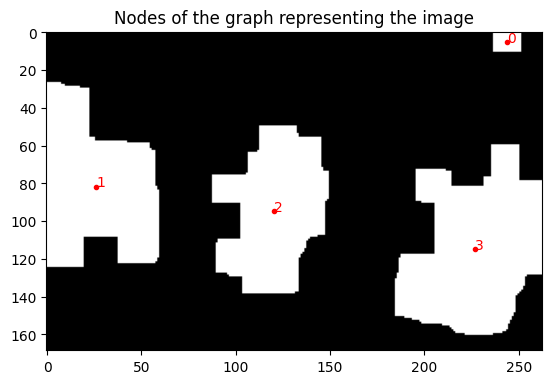

In [35]:
nodes, edges = image_to_graph(img)

#### Fuzzy sets - proximity to the building

Proximity to the building is calculated along each axis seperately and the lower value is chosen. It is done by choosing larger and larger kernels for each pixel and checking when a building will apear inside a kernel. 

Visualize the fuzzy curves:

In [36]:
def building_curve(dist, kernel_ratio, num_of_kernels):
    max_kernel = num_of_kernels*kernel_ratio
    kernel_sizes = [i* kernel_ratio for i in range(1, num_of_kernels+1)]
    if dist == 0:
        return 1
    for kernel_size in kernel_sizes:
        if dist <= kernel_size:
            return (max_kernel - kernel_size) / max_kernel
        
        
def background_curve(dist, kernel_ratio, num_of_kernels):
    max_kernel = num_of_kernels*kernel_ratio
    kernel_sizes = [i* kernel_ratio for i in range(1, num_of_kernels+1)]
    if dist == 0:
        return 0
    for kernel_size in kernel_sizes:
        if dist <= kernel_size:
            return 1 - (max_kernel - kernel_size) / max_kernel
        

def visualize_curves_1():      
    x = np.linspace(0.0, 100.0, num=1000)
    sc = np.linspace(0.0, 100.0, num=1000)
    y1 = [building_curve(i, 3, 10) for i in sc]
    y2 = [background_curve(i, 3, 10) for i in sc]
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.title("Fuzzy functions to determine membership to the building/background")
    plt.legend(["Building", "Background"])
    plt.xlabel("Distance to the building")
    plt.ylabel("Membership")

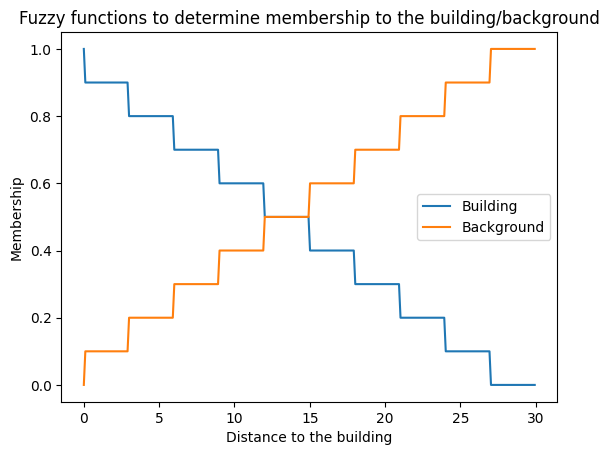

In [37]:
visualize_curves_1()

In [38]:
def fuzzify(img, kernel_ratio=3, num_of_kernels=10, plot=True):
    img_norm = np.array(img) / 255
    fuzzified = np.zeros(np.shape(img_norm))
    max_kernel = num_of_kernels*kernel_ratio
    kernel_sizes = [i* kernel_ratio for i in range(1, num_of_kernels+1)]
    for i in range(np.shape(img_norm)[0]):
        for j in range(np.shape(img_norm)[1]):
                if img_norm[i, j] == 1:
                    fuzzified[i, j] = 1
                else:
                    for kernel_size in kernel_sizes:
                        if np.max(img_norm[max((i-kernel_size), 0):min((i+kernel_size), np.shape(img_norm)[0]), \
                                           max((j-kernel_size), 0):min((j+kernel_size), np.shape(img_norm)[1])]) == 1:
                            fuzzified[i, j] = (max_kernel - kernel_size) / max_kernel
                            break

    if plot:
#         plt.imshow(img, cmap="gray")
#         plt.title("Original image")
#         plt.show()
        plt.imshow(fuzzified, cmap="gray")
        plt.title("Fuzzified values of pixels")
        plt.show()
    return fuzzified   

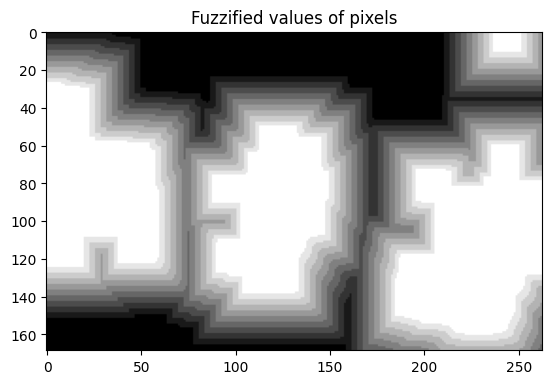

In [39]:
fuzz = fuzzify(img, kernel_ratio=3, num_of_kernels=10)

## Gruond truth image

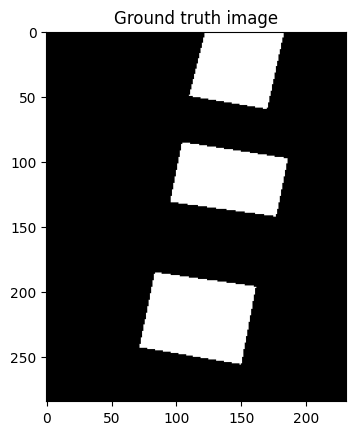

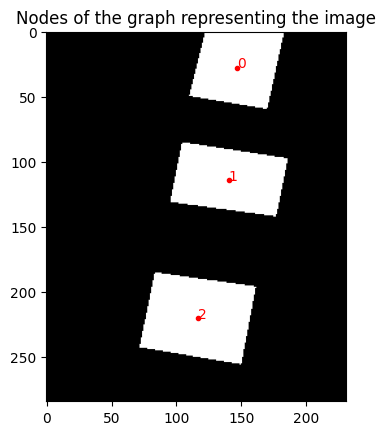

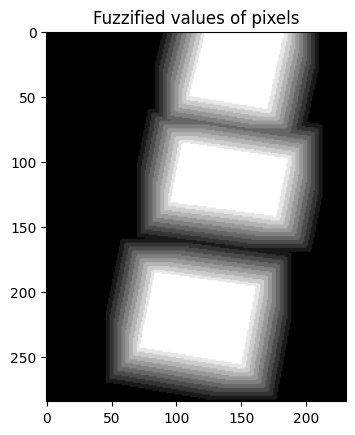

In [40]:
img_truth = cv2.imread("map1_truth2.png")
img_truth = np.array(cv2.cvtColor(img_truth, cv2.COLOR_BGR2GRAY))
ret, img_truth = cv2.threshold(img_truth,100,255,cv2.THRESH_BINARY)
plt.imshow(img_truth, cmap="gray")
plt.title("Ground truth image")
plt.show()

nodes_truth, edges_truth = image_to_graph(img_truth)
fuzz_truth = fuzzify(img_truth, kernel_ratio=3, num_of_kernels=10)

## Compare the images

### Match graphs representing the images

Compare paths in the graphs. Search for patterns of three nodes in analogical distances (congruent triangles).

In [41]:
def compare_graphs(edges1, edges2, margin=0.1):
    output_paths = []
    for n1 in range(edges1.shape[0]):
        for i1 in range(edges1.shape[1] - 1):
            for j1 in range(edges1.shape[1] - 1):
                if edges1[n1, i1] != 0 and edges1[n1, j1] != 0 and i1 != j1:
                    rate1 = edges1[n1, i1] / edges1[n1, j1]
                    for n2 in range(edges2.shape[0]):
                        for i2 in range(edges2.shape[1] - 1):
                            for j2 in range(edges2.shape[1] - 1):
                                if edges2[n2, i2] != 0 and edges2[n2, j2] != 0 and i2 != j2:
                                    rate2 = edges2[n2, i2] / edges2[n2, j2]

                                    if rate1 / rate2 < 1+margin and rate1 / rate2 > 1-margin:
                                        rate1_next = edges1[i1, j1] / min(edges1[n1, i1], edges1[n1, j1])
                                        rate2_next = edges2[i2, j2] / min(edges2[n2, i2], edges2[n2, j2])
                                        if rate1_next / rate2_next < 1+margin and rate1_next / rate2_next > 1-margin:
                                            output_paths.append([(n1, i1, j1), (n2, i2, j2)])
    return output_paths        

In [42]:
potential_pairings = compare_graphs(edges, edges_truth, margin=0.2)
print(potential_pairings)

[[(3, 1, 2), (2, 0, 1)], [(3, 2, 1), (2, 1, 0)]]


### Match the images

In [43]:
import math

def getAngleLine(coord1, coord2):
    x_orig, y_orig = coord1
#     print(x_orig, y_orig)
    x_landmark, y_landmark = coord2
#     print(x_landmark, y_landmark)
    deltaY = y_landmark - y_orig
    deltaX = x_landmark - x_orig
    angle_rad = math.atan2(deltaY, deltaX) #angle_trunc(atan2(deltaY, deltaX))
    return angle_rad * 180 / math.pi



In [44]:
def cv2_clipped_zoom(img, zoom_factor=0):
    if zoom_factor == 0:
        return img


    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

In [45]:
import imutils

def rotate_center(center, angle_rotate, shape_in):
    black = np.zeros(shape_in)
    black[math.floor(center[1]), math.floor(center[0])] = 1
    black = imutils.rotate_bound(black, -angle_rotate)
    max_value = np.max(np.max(black))
    swapped = list(zip(*np.where(black == max_value)))[0]
    return np.array([swapped[1], swapped[0]])

def resize_center(center, shape_old, shape_new):
    black = np.zeros(shape_old)
    black[math.floor(center[1]), math.floor(center[0])] = 1
    black = cv2.resize(black, (shape_new[1],  shape_new[0]))
    max_value = np.max(np.max(black))
    swapped = list(zip(*np.where(black == max_value)))[0]
    return np.array([swapped[1], swapped[0]])


def zoom_center(center, scale, shape_in):
    black = np.zeros(shape_in)
    black[math.floor(center[1]), math.floor(center[0])] = 1
    black = cv2_clipped_zoom(black, scale)
    max_value = np.max(np.max(black))
    swapped = list(zip(*np.where(black == max_value)))[0]
    return np.array([swapped[1], swapped[0]])


def new_edges(nodes):
    edges = np.zeros((len(nodes), len(nodes)))
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            edges[i, j] = distance(nodes[i, 0], nodes[i, 1], nodes[j, 0], nodes[j, 1])
    return edges

In [46]:
from PIL import Image, ImageChops
from copy import deepcopy

def compare_pair(pairing, img, nodes, edges, img_truth, nodes_truth, edges_truth, plot=True):
    img_new = deepcopy(img)
    img_org = deepcopy(img_truth)
    nodes_org = deepcopy(nodes_truth)
    edges_org = deepcopy(edges_truth)
    nodes_new = deepcopy(nodes)
    edges_new = deepcopy(edges)
    
    if plot:
        show_centers(img_new, nodes_new)
        show_centers(img_org, nodes_org)
    
    # 1. ROTATION: rotate by the angle between corresponding lines (edges)
    angle1_1 = getAngleLine(nodes_new[pairing[0][0]], nodes_new[pairing[0][1]])
    angle1_truth = getAngleLine(nodes_org[pairing[1][0]], nodes_org[pairing[1][1]])
    angle_rotate = angle1_1 - angle1_truth
    imsize_old = img_new.shape
    img_new = imutils.rotate_bound(img_new, -angle_rotate)
    
    # rotate centers
    for i in range(len(nodes_new)):
        nodes_new[i] = rotate_center(nodes_new[i], angle_rotate, imsize_old)
        
    if plot:
        print("----ROTATION----")
        show_centers(img_new, nodes_new)
        show_centers(img_org, nodes_org)

    
    # 2. RESIZING: the images should have the same size
    # resize centers
    for i in range(len(nodes_new)):
        nodes_new[i] = resize_center(nodes_new[i], img_new.shape, img_org.shape)
    edges_new = new_edges(nodes_new)
    # resize image
    img_new = cv2.resize(img_new, (img_org.shape[1],  img_org.shape[0]))

    
    # 3. RESCALING: scale by the ratio between corresponding lines. Always zooming out the larger image to avoid loosing data
    # scale image
    dist1_1 = edges_new[pairing[0][0]][pairing[0][1]]
    dist1_truth = edges_org[pairing[1][0]][pairing[1][1]]
    
    # always zoom out - not to loose cropped data
    if dist1_truth < dist1_1:
        scale = dist1_truth / dist1_1
        img_new = cv2_clipped_zoom(img_new, scale)
        for i in range(len(nodes_new)):
            nodes_new[i] = zoom_center(nodes_new[i], scale, img_new.shape)
            edges_new = new_edges(nodes_new)
        
    elif dist1_1 < dist1_truth:
        scale = dist1_1 / dist1_truth
        img_org = cv2_clipped_zoom(img_org, scale)
        for i in range(len(nodes_org)):
            nodes_org[i] = zoom_center(nodes_org[i], scale, img_org.shape)
            edges_org = new_edges(nodes_org)
            
    if plot:
        print("----RESCALE----")
        show_centers(img_new, nodes_new)
        show_centers(img_org, nodes_org)

        
    # 4. TRANSLATE: align the images based in the offset between corresponding centers
    offset_x = int(nodes_new[pairing[0][0]][0] - nodes_org[pairing[1][0]][0])
    offset_y = int(nodes_new[pairing[0][0]][1] - nodes_org[pairing[1][0]][1])
#     cv2.imwrite('tmp.png', img_new)
#     img_new = Image.open(r"tmp.png")
#     img_new = ImageChops.offset(img_new, -offset_x, -offset_y)

    height, width = img_new.shape[:2]
    T = np.float32([[1, 0, -offset_x], [0, 1, -offset_y]])
    img_new = cv2.warpAffine(img_new, T, (width, height))
    
    nodes_new[:, 0] = nodes_new[:, 0] - offset_x
    nodes_new[:, 1] = nodes_new[:, 1] - offset_y
    
    if plot:
        print("----TRANSLATE----")
        show_centers(img_new, nodes_new)
        show_centers(img_org, nodes_org)
    
    
    # 5. FUZZIFY BOTH IMAGES
    kernel_ratio = 3
    num_of_kernels = 10
    fuzz_new = fuzzify(img_new, kernel_ratio=kernel_ratio, num_of_kernels=num_of_kernels)
    fuzz_org = fuzzify(img_org, kernel_ratio=kernel_ratio, num_of_kernels=num_of_kernels)
    
    if plot:
        print("----FUZZIFY----")
        show_centers(fuzz_new, nodes_new)
        show_centers(fuzz_org, nodes_org)

    
    # 6. COMPARE IMAGES PIXEL BY PIXEL
    diff = np.abs(fuzz_new - fuzz_org)
    if plot:
        print("----COMPARE----")
        plt.imshow(diff, cmap='gray')
        plt.title("Difference between images")
        plt.show()
    
    diff_mean = np.mean(np.mean(diff))
    max_diff = kernel_ratio * num_of_kernels
    result = (max_diff - diff_mean) / max_diff
    return result

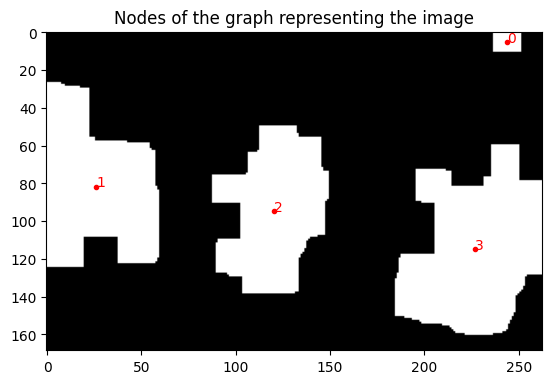

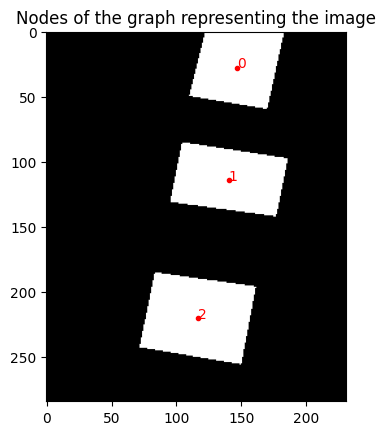

----ROTATION----


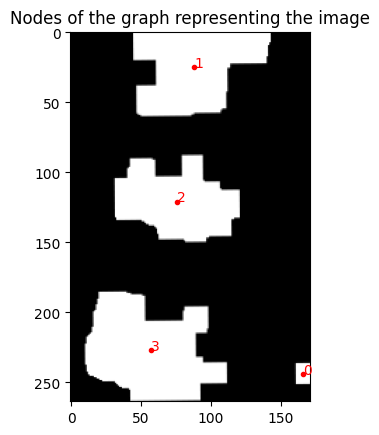

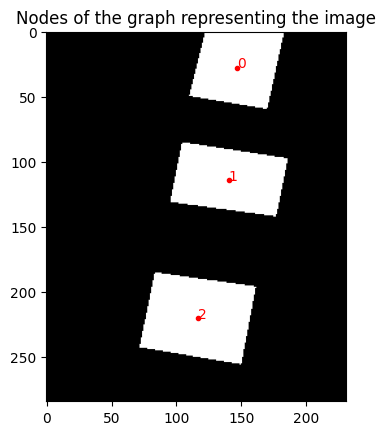

C:\Users\gosia\AppData\Local\Temp\ipykernel_2920\4102882090.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bbox = (bbox / zoom_factor).astype(np.int)


----RESCALE----


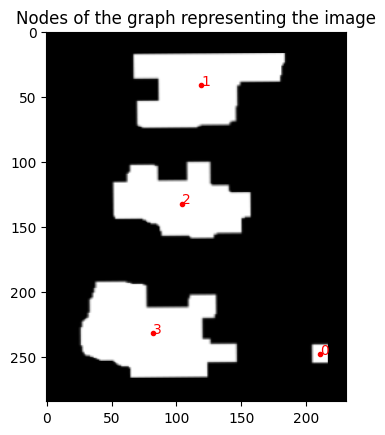

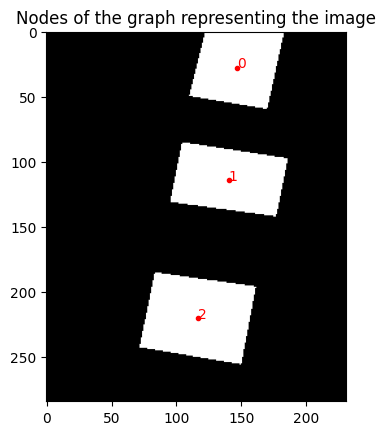

----TRANSLATE----


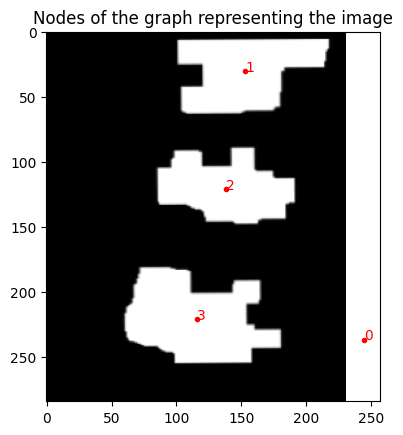

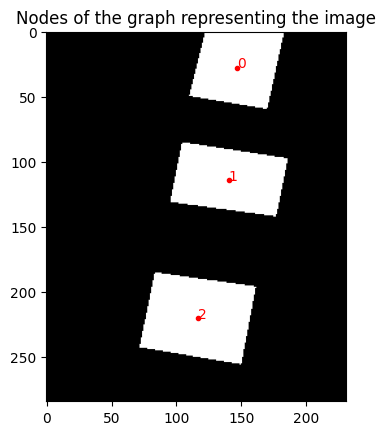

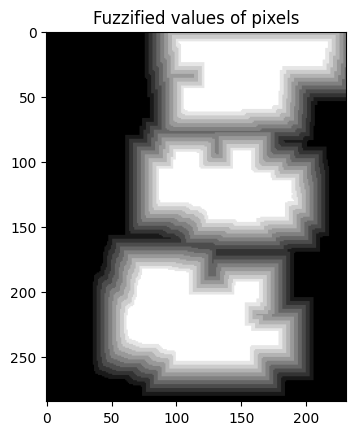

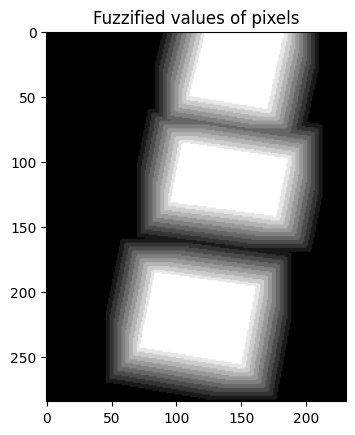

----FUZZIFY----


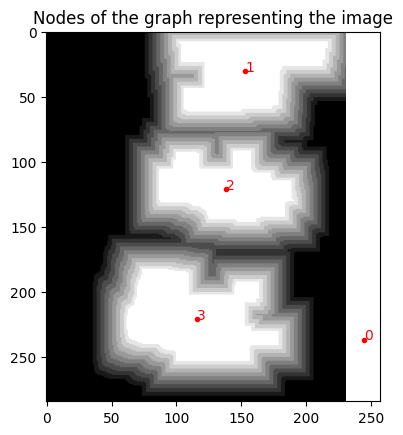

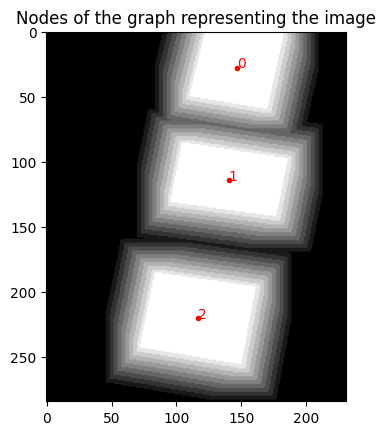

----COMPARE----


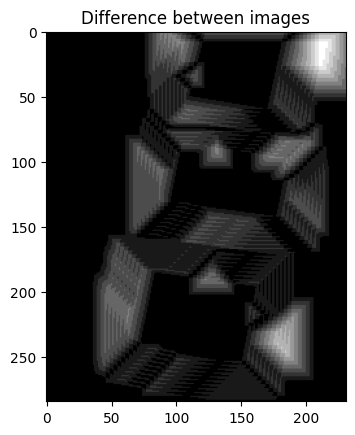

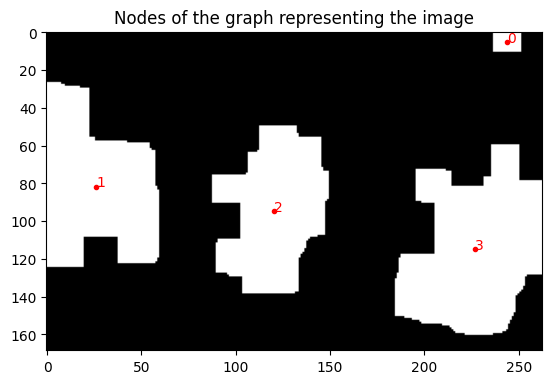

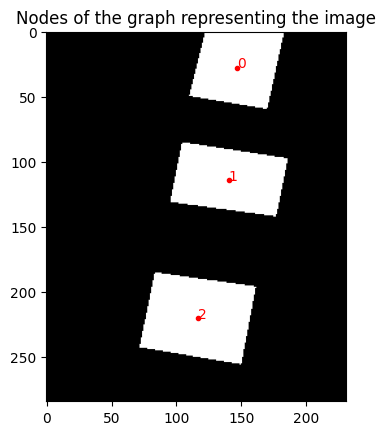

----ROTATION----


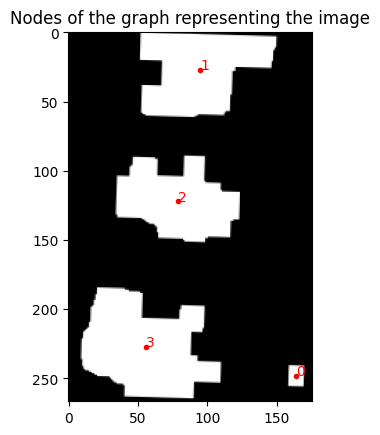

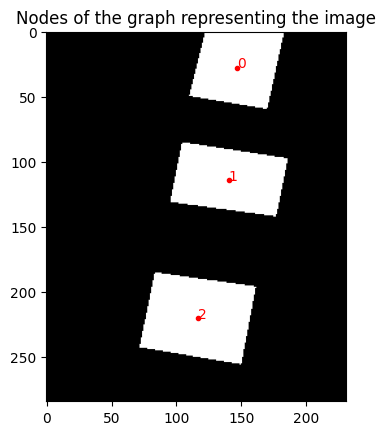

----RESCALE----


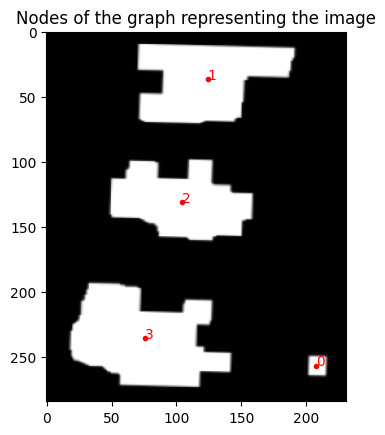

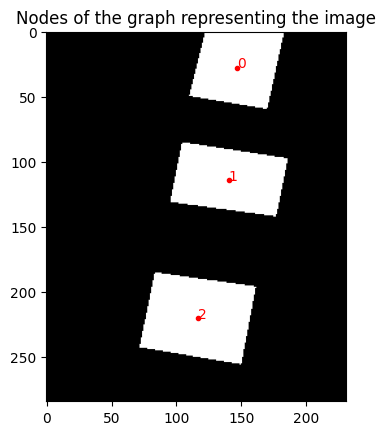

----TRANSLATE----


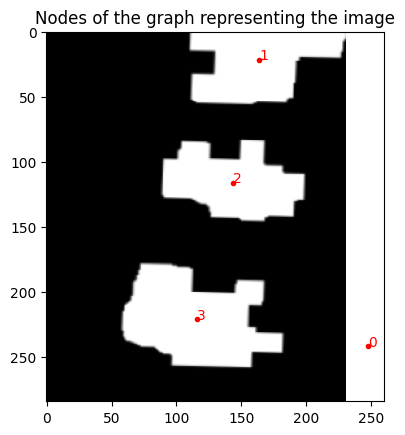

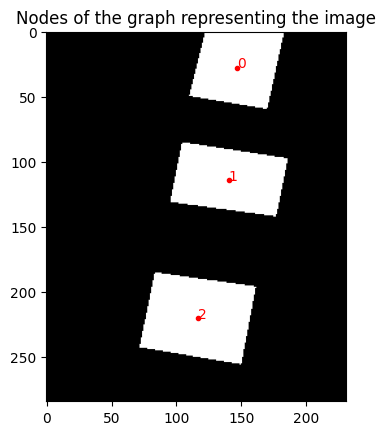

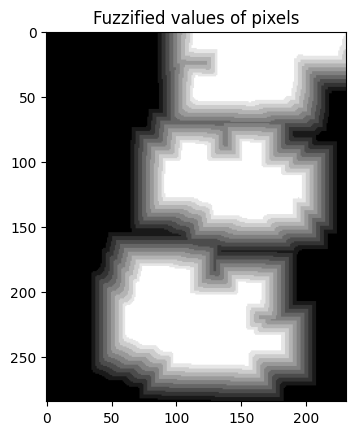

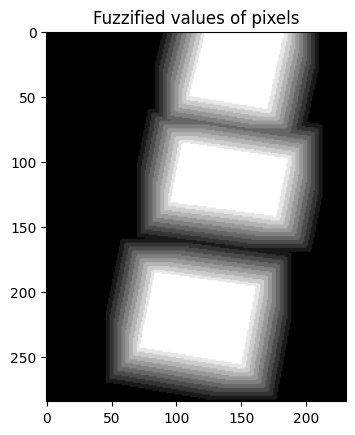

----FUZZIFY----


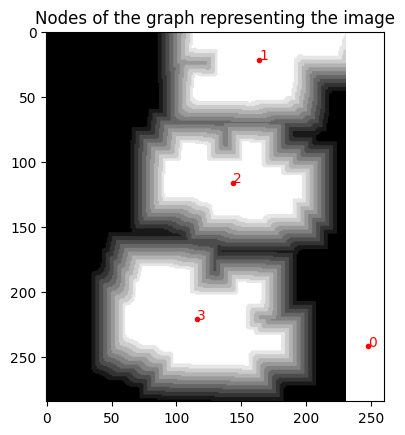

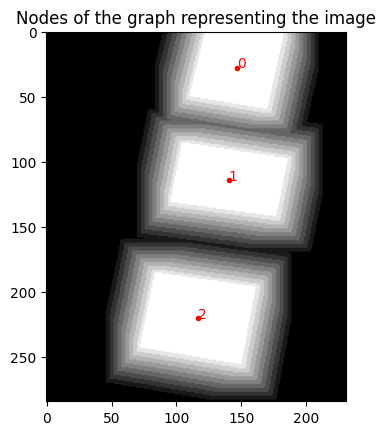

----COMPARE----


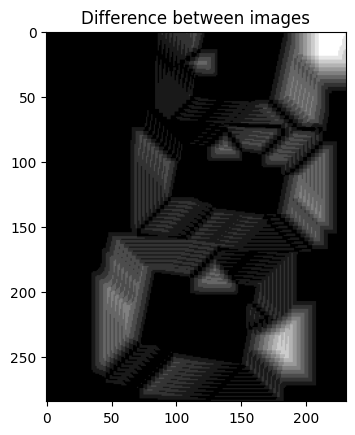

In [47]:
results_list = []
for pairing in potential_pairings:
    result = compare_pair(pairing, img, nodes, edges, img_truth, nodes_truth, edges_truth)
    results_list.append(result)

max_result = np.max(results_list)

## Fuzzify the result

In [48]:
def low_curve(score, thr1=0.2, thr2=0.45):
    if score <= thr1:
        return 1
    if thr1 < score < thr2:
        return round(1 - (1 / (thr2 - thr1)) * (score - thr1), 2)
    return 0

def medium_curve(score, thr1=0.2, thr2=0.45, thr3=0.55, thr4=0.8):
    if thr1 < score < thr2:
        return round((1 / (thr2 - thr1)) * (score - thr1), 2)
    if thr2 <= score <= thr3:
        return 1
    if thr3 < score < thr4:
        return round(1 - (1 / (thr4 - thr3)) * (score - thr3), 2)
    return 0

def high_curve(score, thr3=0.55, thr4=0.8):
    if thr3 < score < thr4:
        return round((1 / (thr4 - thr3)) * (score - thr3), 2)
    if score >= thr4:
        return 1
    return 0

Text(0.5, 1.0, 'Fuzzy functions to determine images similarity')

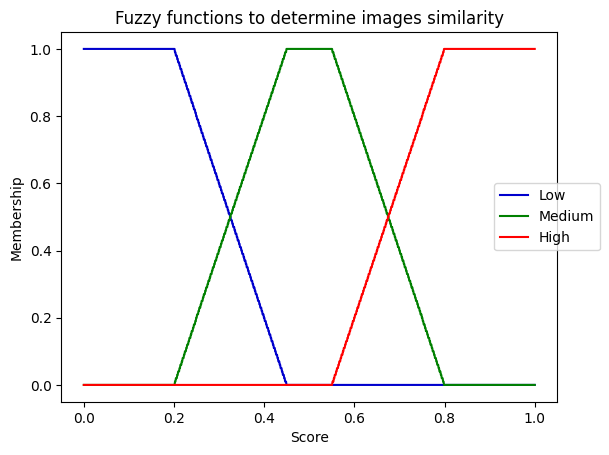

In [49]:
### Visualize fuzzy functions
x = np.linspace(0.0, 1.0, num=1000)
sc = np.linspace(0.0, 1.0, num=1000)
y1 = [low_curve(i, 0.2, 0.45) for i in sc]
y2 = [medium_curve(i, 0.2, 0.45, 0.55, 0.8) for i in sc]
y3 = [high_curve(i, 0.55, 0.8) for i in sc]
plt.plot(x, y1, 'mediumblue')
plt.plot(x, y2, 'g')
plt.plot(x, y3, 'r')
plt.ylabel("Membership")
plt.xlabel("Score")
plt.legend(['Low', 'Medium', 'High'], loc="center right", bbox_to_anchor=(1.1, 0.5))
plt.title("Fuzzy functions to determine images similarity")

In [50]:
print(f"The result is equal to {max_result}")
print(f"Its membership to the fuzzy sets: Low similarity: {low_curve(max_result)}, medium similarity: {medium_curve(max_result)}, high similarity: {high_curve(max_result)}")

The result is equal to 0.9966604389762285
Its membership to the fuzzy sets: Low similarity: 0, medium similarity: 0, high similarity: 1


# Other examples

The above code collected:

In [51]:
def compare(img_path1, img_path_truth, plot=False):
    img = cv2.imread(img_path1)
    if plot:
        plt.imshow(img)
        plt.title("Photo")
        plt.show()
    img = eliminate_green(img, plot=plot)
    img = segment_buildings(img, plot=plot)
    nodes, edges = image_to_graph(img, plot=plot)
    fuzz = fuzzify(img, kernel_ratio=3, num_of_kernels=10, plot=plot)
    
    img_truth = cv2.imread(img_path_truth)
    img_truth = np.array(cv2.cvtColor(img_truth, cv2.COLOR_BGR2GRAY))
    ret, img_truth = cv2.threshold(img_truth,100,255,cv2.THRESH_BINARY)
    if plot:
        plt.imshow(img_truth, cmap="gray")
        plt.title("Ground truth image")
        plt.show()
    nodes_truth, edges_truth = image_to_graph(img_truth, plot=plot)
    fuzz_truth = fuzzify(img_truth, kernel_ratio=3, num_of_kernels=10, plot=plot)
    
    potential_pairings = compare_graphs(edges, edges_truth, margin=0.2)
    results_list = []
    for pairing in potential_pairings:
        result = compare_pair(pairing, img, nodes, edges, img_truth, nodes_truth, edges_truth)
        results_list.append(result)
    max_result = np.max(results_list)
    
    print(f"The result is equal to {max_result}")
    print(f"Its membership to the fuzzy sets: Low similarity: {low_curve(max_result)}, \
    medium similarity: {medium_curve(max_result)}, high similarity: {high_curve(max_result)}")
    return max_result

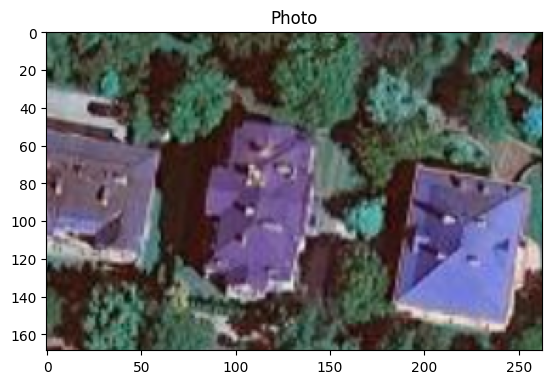

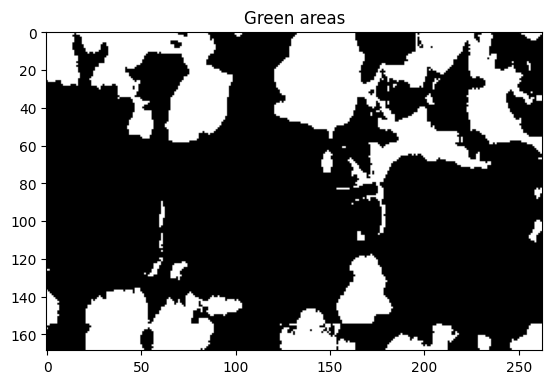

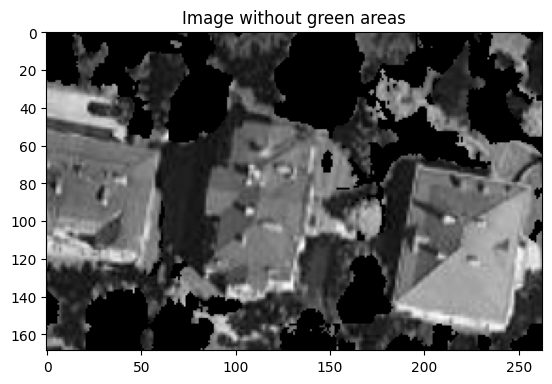

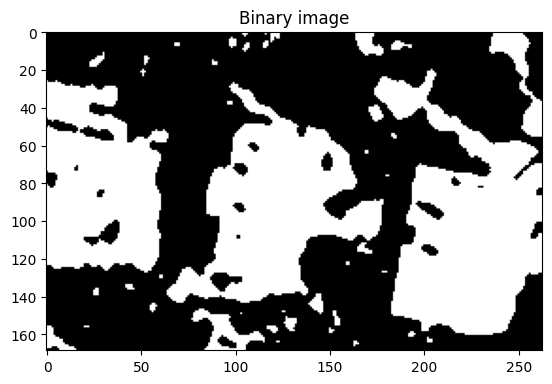

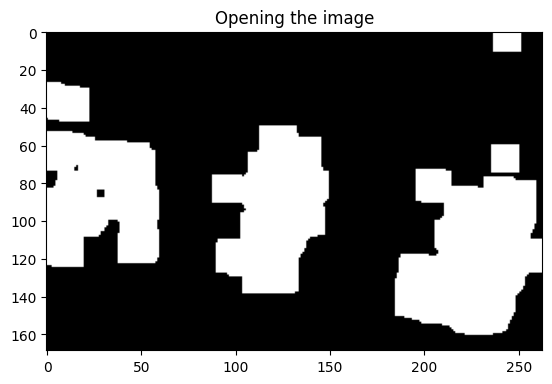

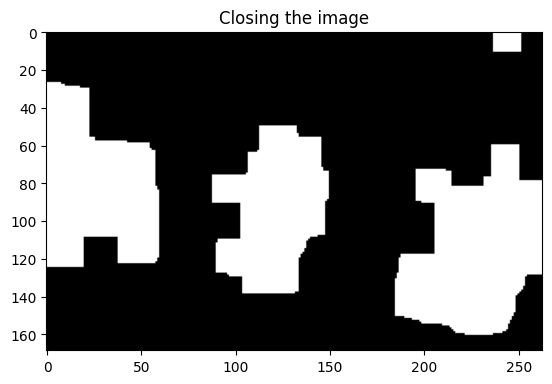

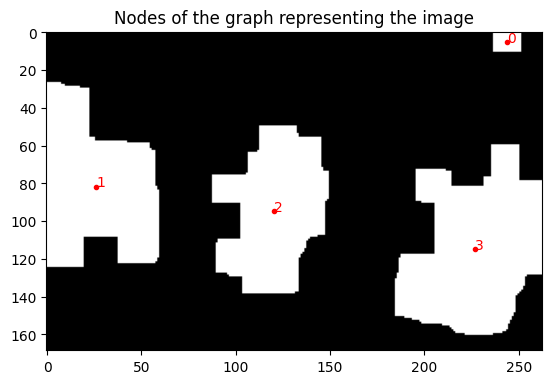

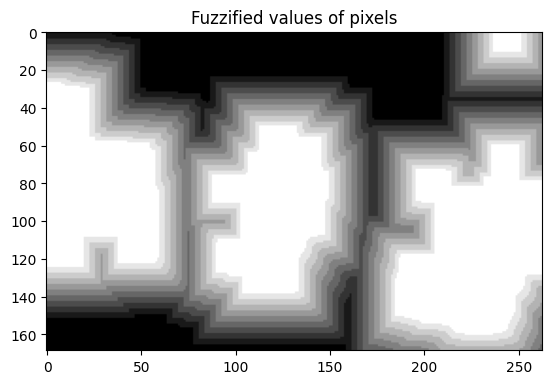

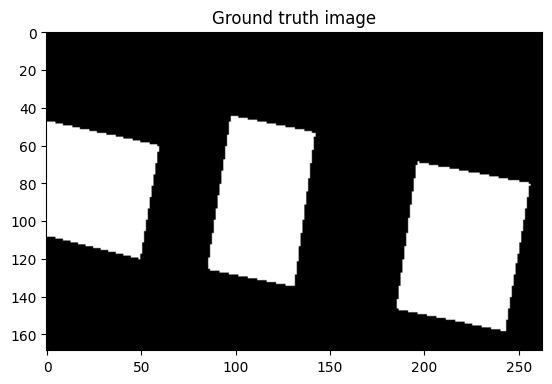

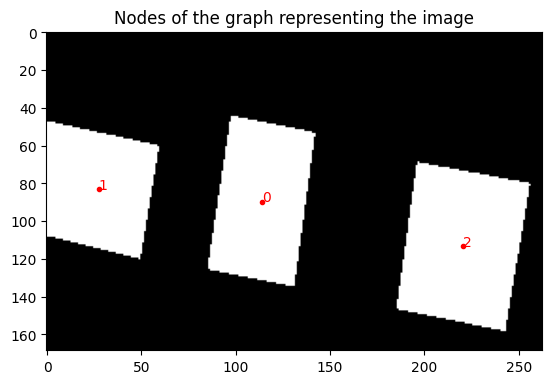

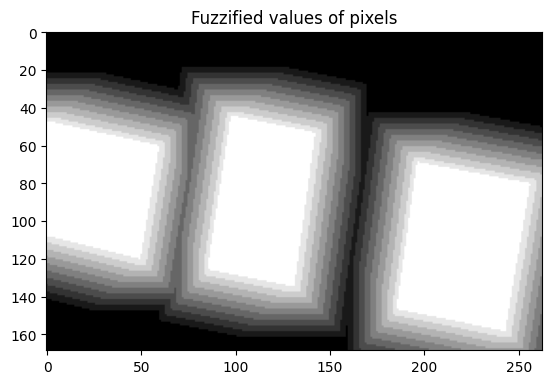

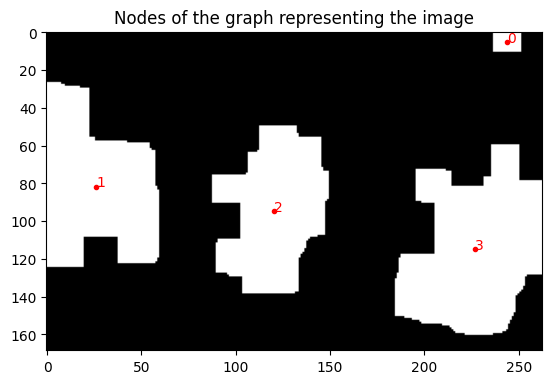

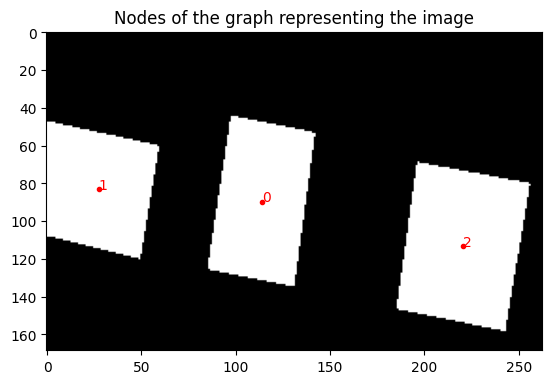

----ROTATION----


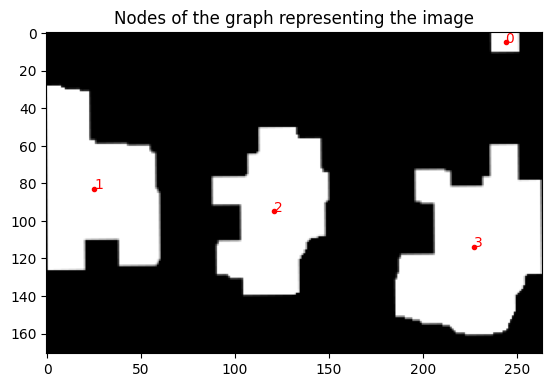

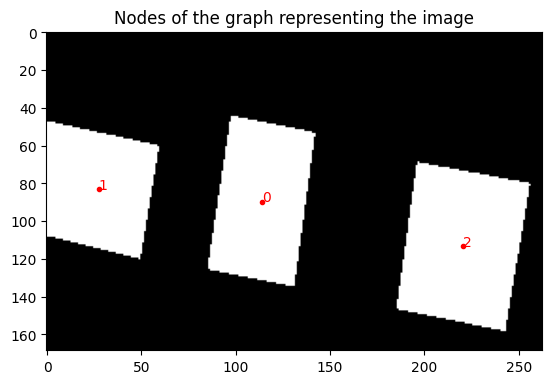

C:\Users\gosia\AppData\Local\Temp\ipykernel_2920\4102882090.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bbox = (bbox / zoom_factor).astype(np.int)


----RESCALE----


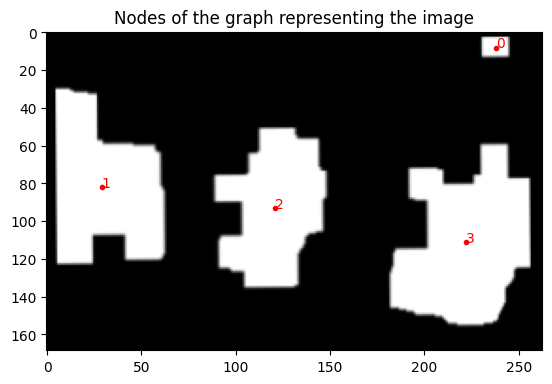

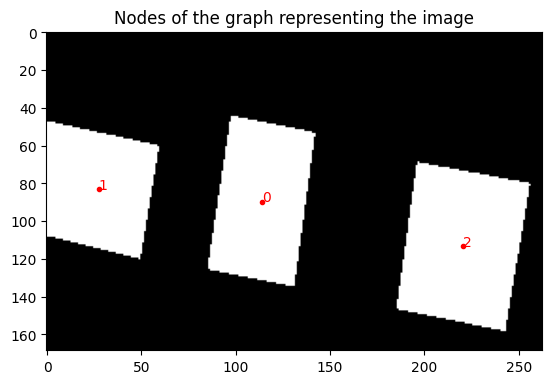

----TRANSLATE----


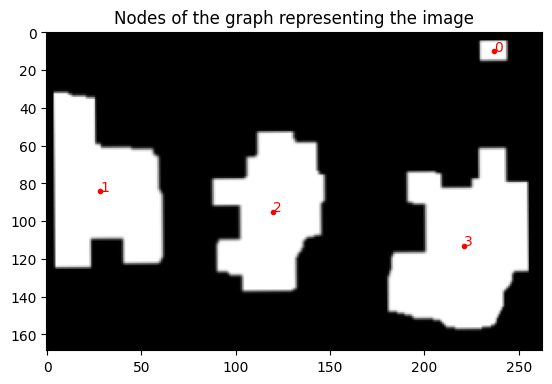

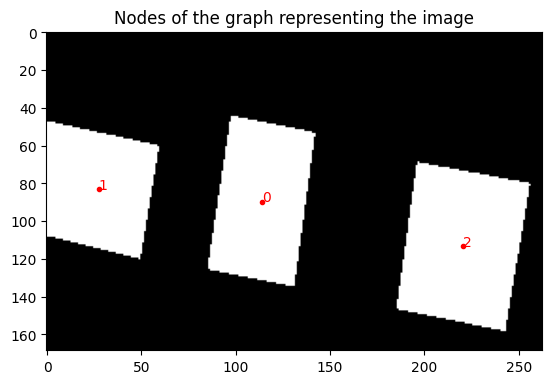

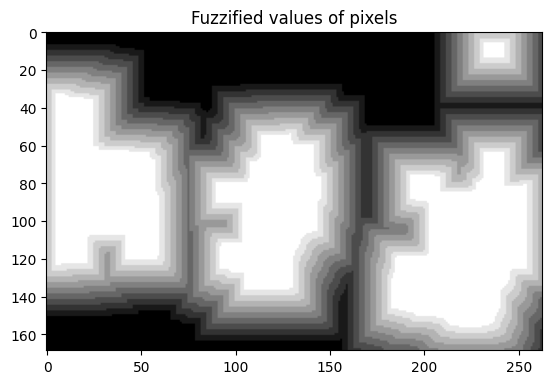

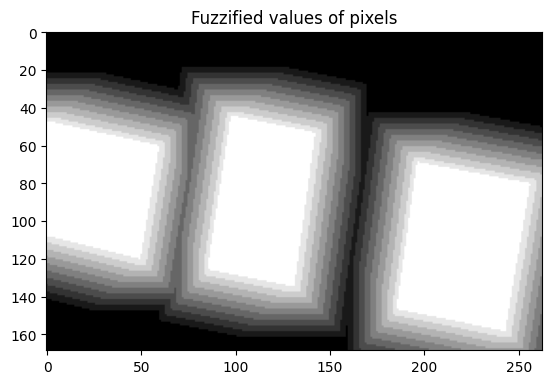

----FUZZIFY----


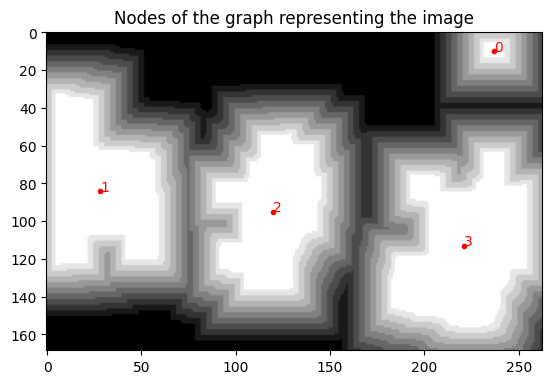

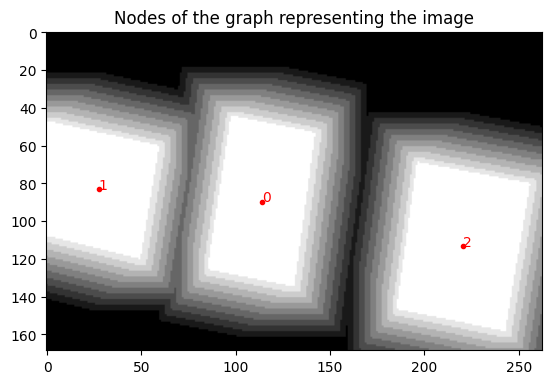

----COMPARE----


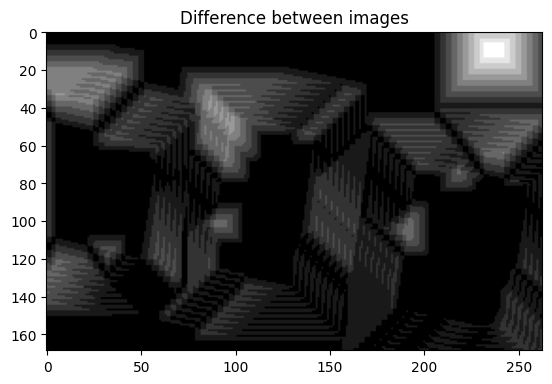

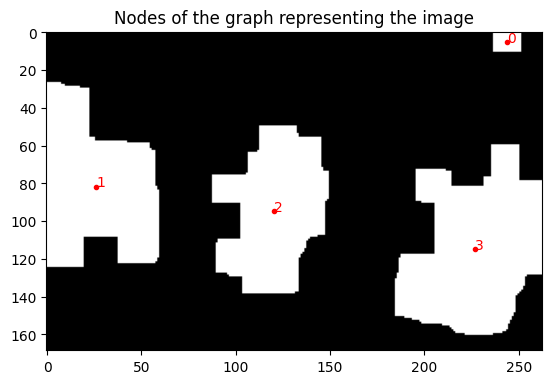

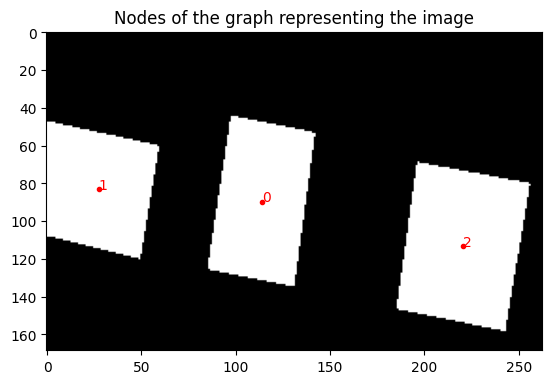

----ROTATION----


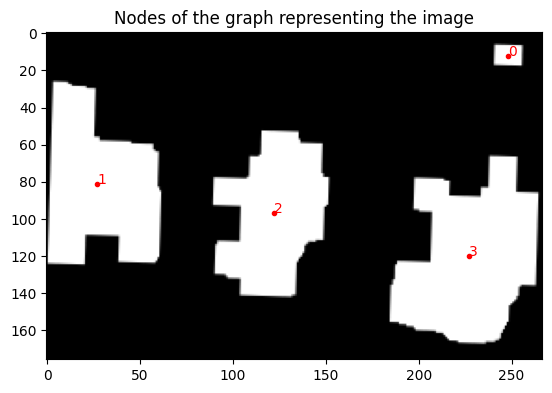

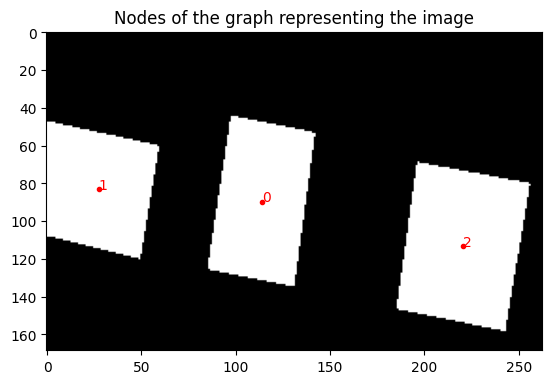

----RESCALE----


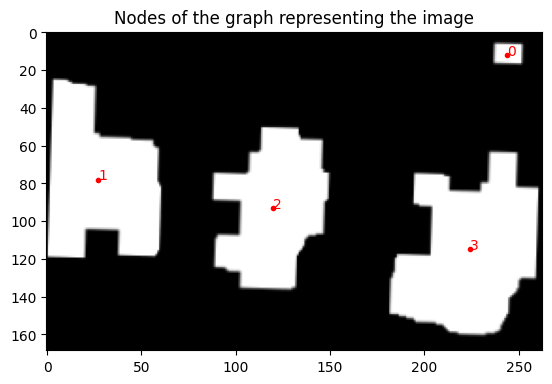

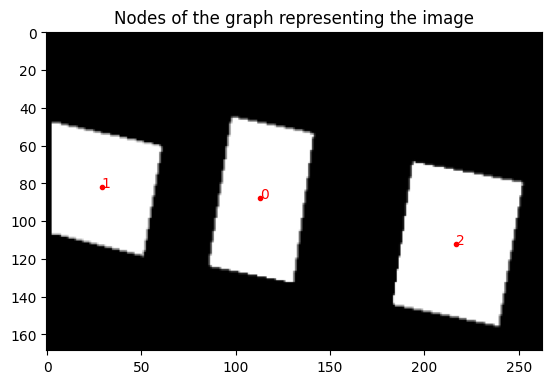

----TRANSLATE----


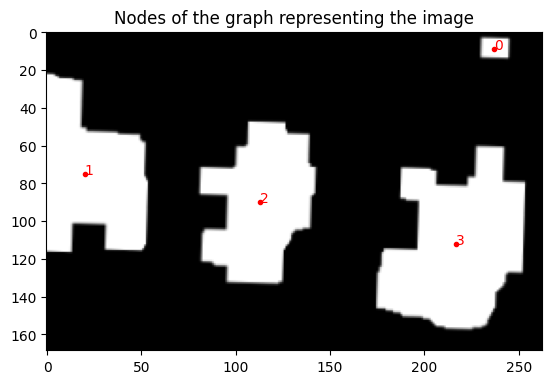

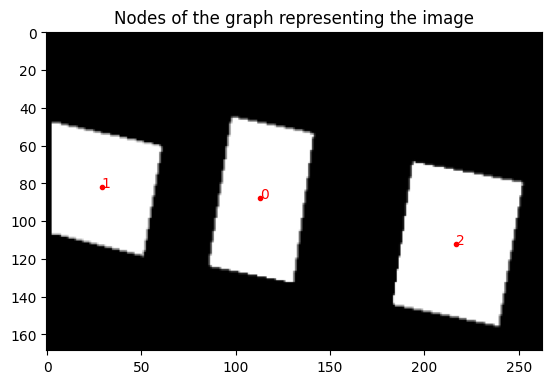

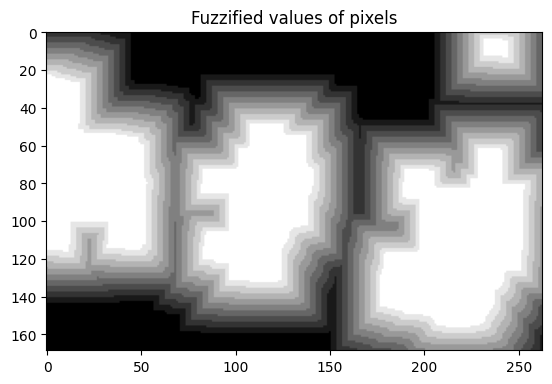

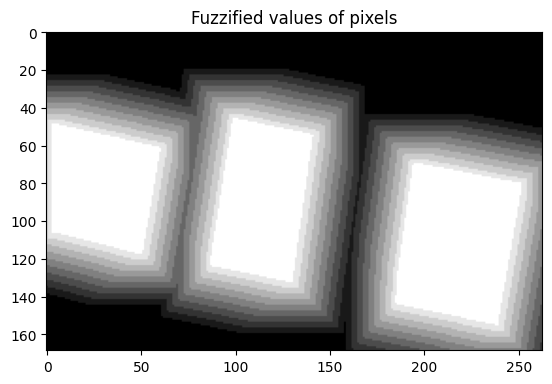

----FUZZIFY----


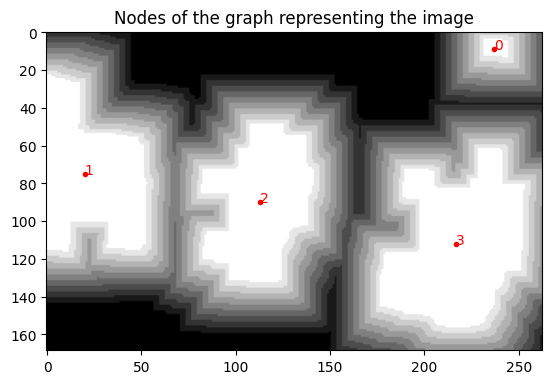

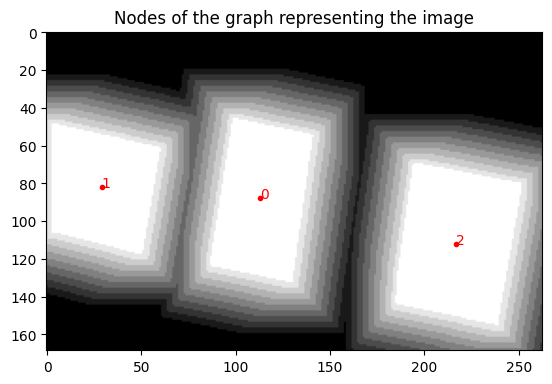

----COMPARE----


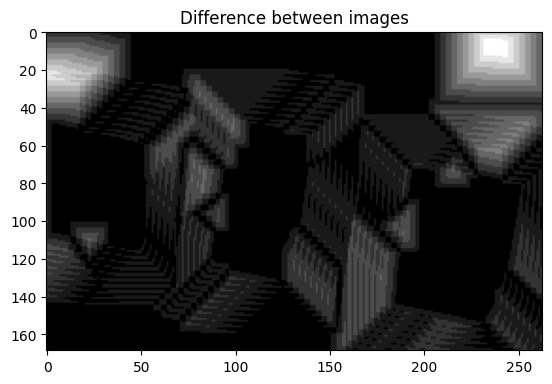

The result is equal to 0.9964137062118928
Its membership to the fuzzy sets: Low similarity: 0,     medium similarity: 0, high similarity: 1


0.9964137062118928

In [52]:
compare("map1.png", "map1_truth.png", plot=True)

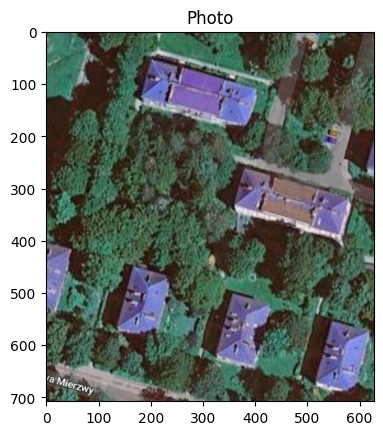

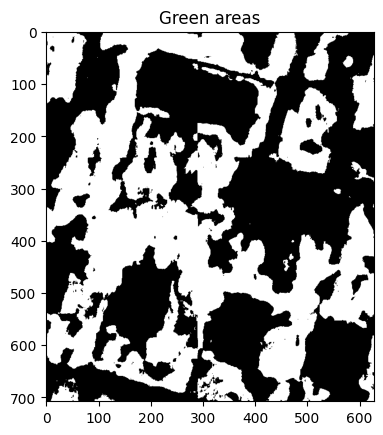

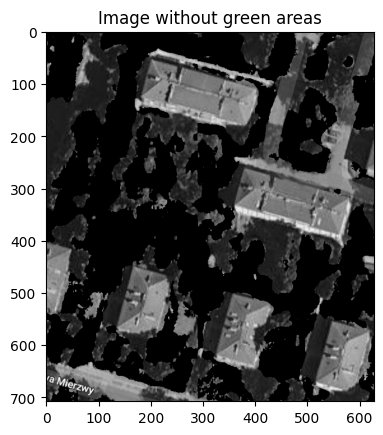

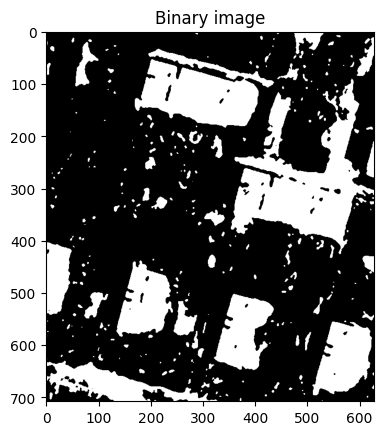

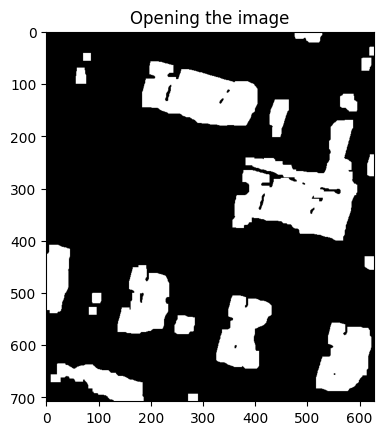

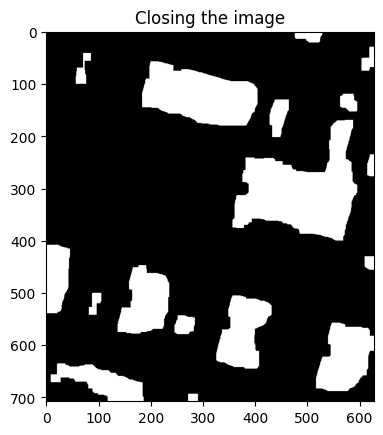

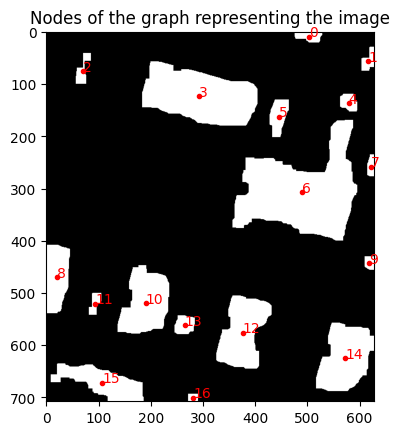

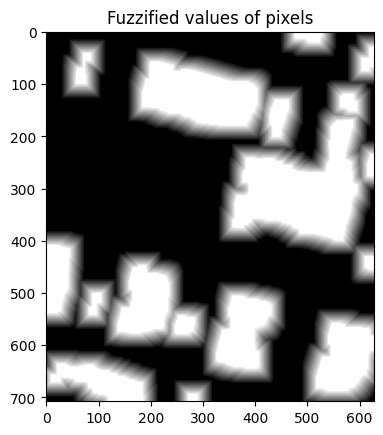

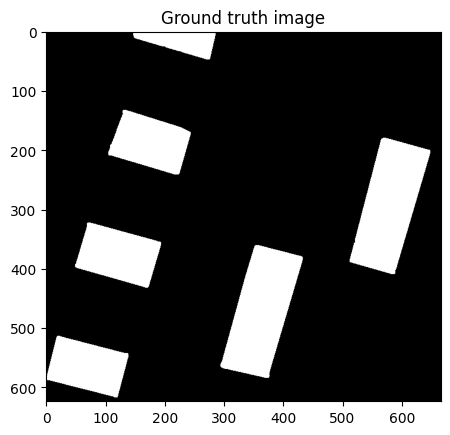

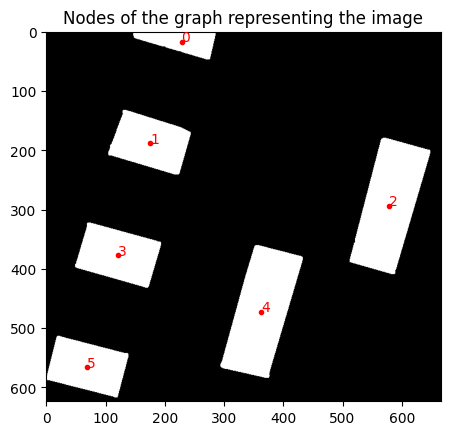

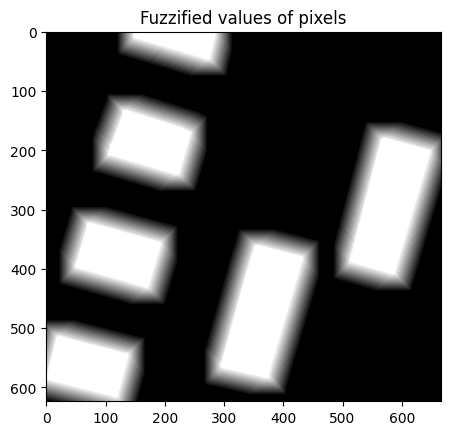

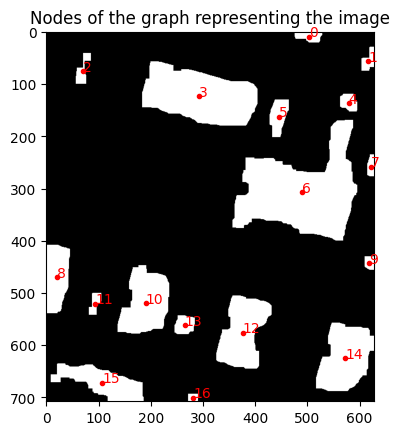

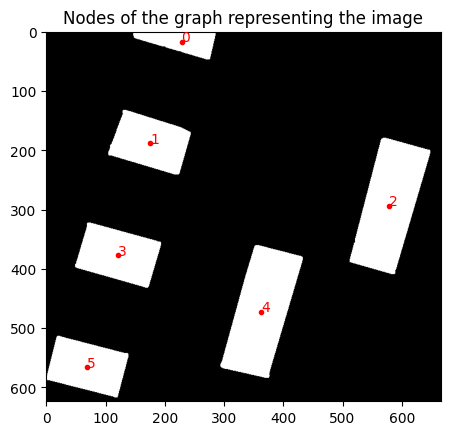

----ROTATION----


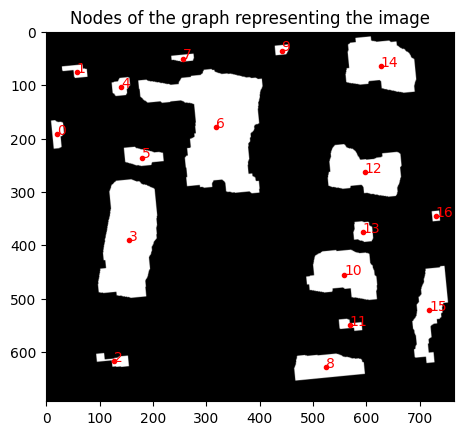

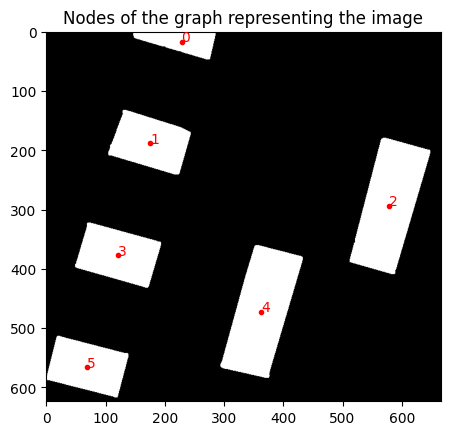

C:\Users\gosia\AppData\Local\Temp\ipykernel_2920\4102882090.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bbox = (bbox / zoom_factor).astype(np.int)


----RESCALE----


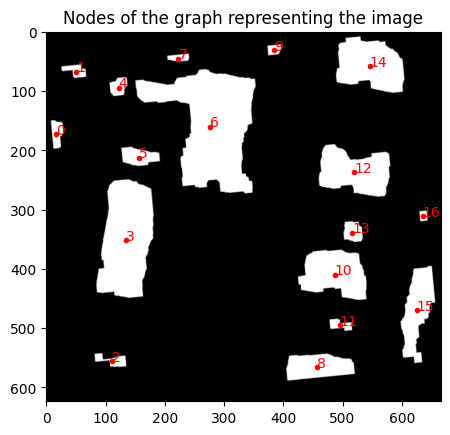

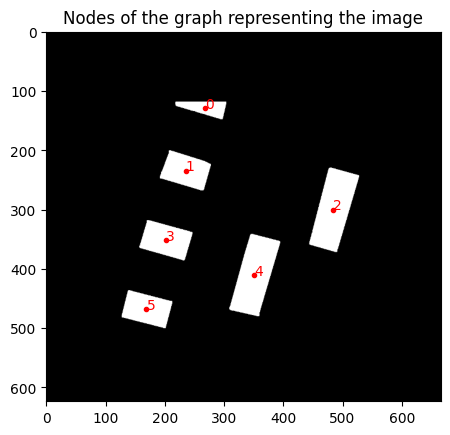

----TRANSLATE----


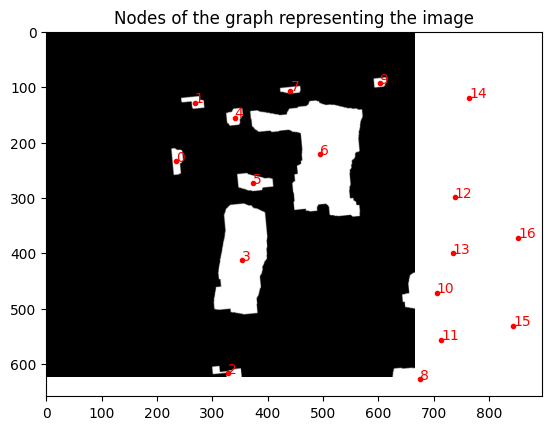

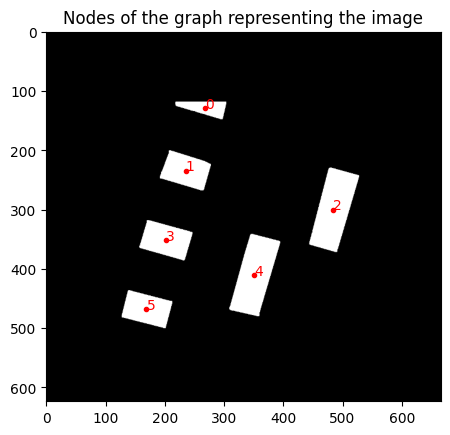

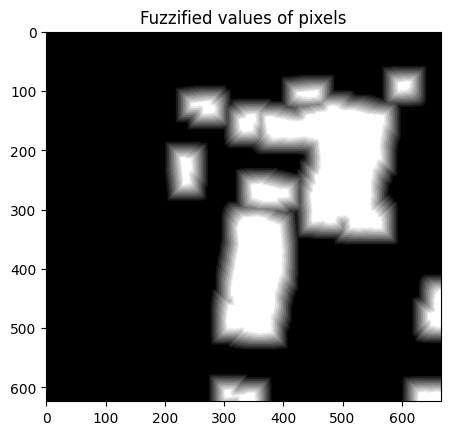

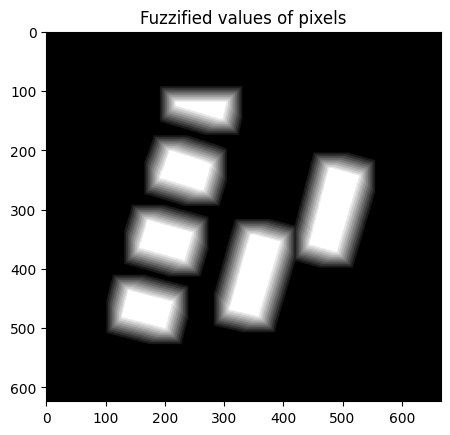

----FUZZIFY----


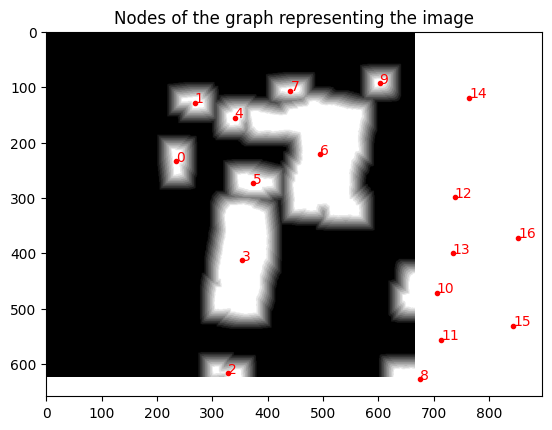

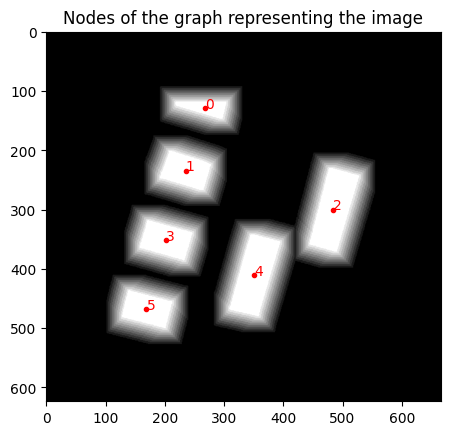

----COMPARE----


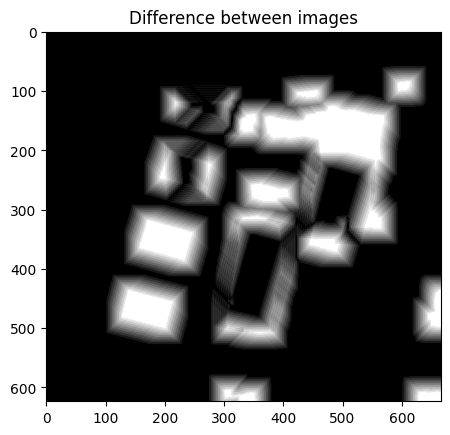

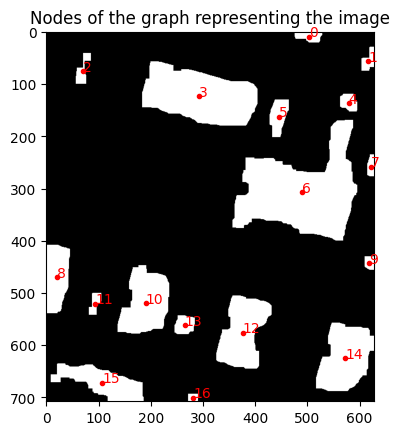

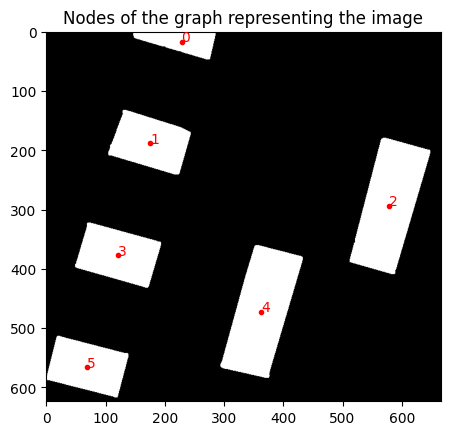

----ROTATION----


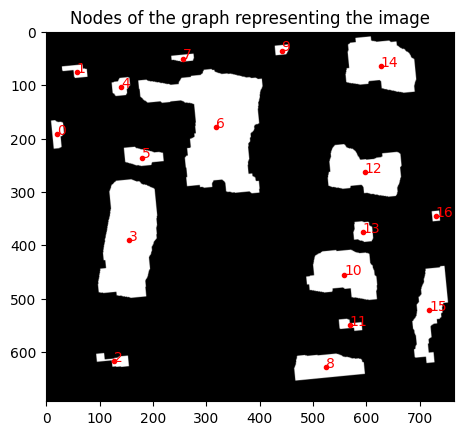

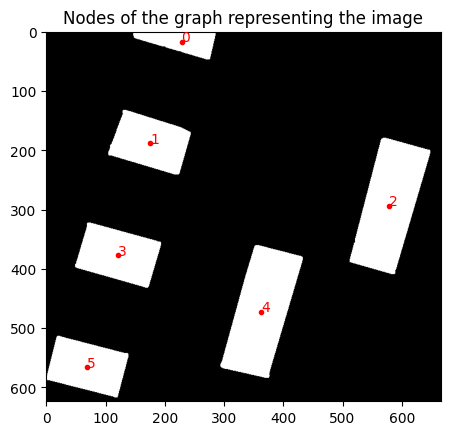

----RESCALE----


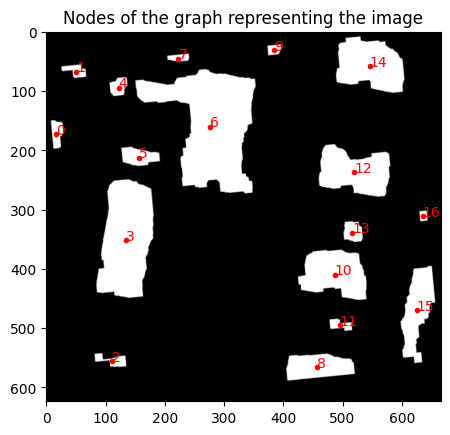

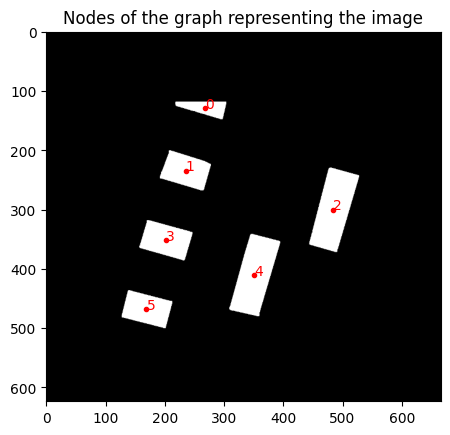

----TRANSLATE----


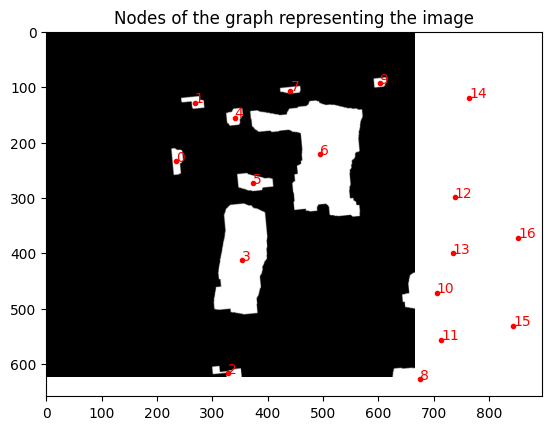

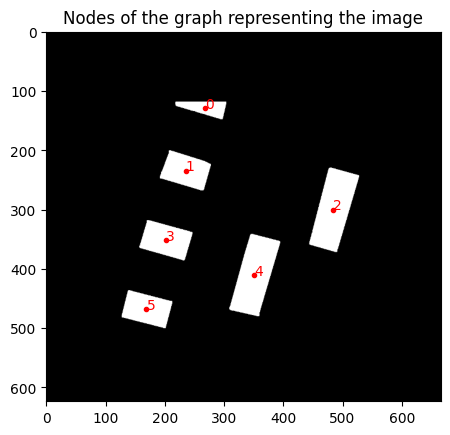

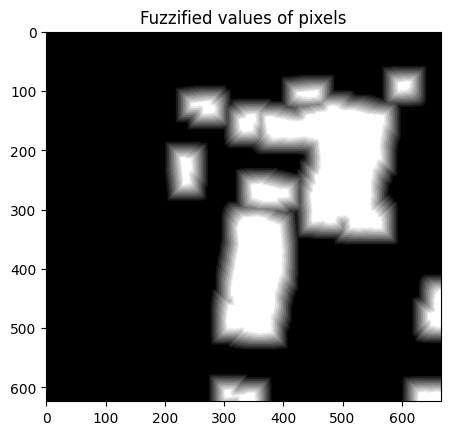

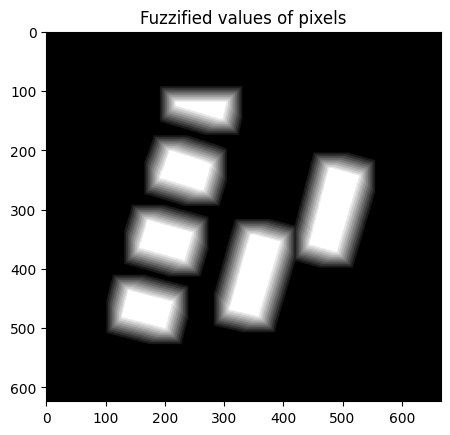

----FUZZIFY----


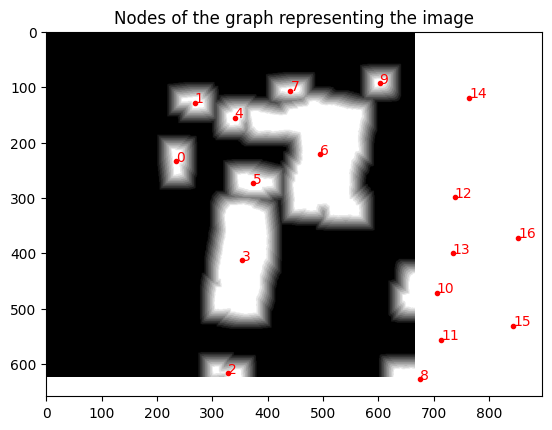

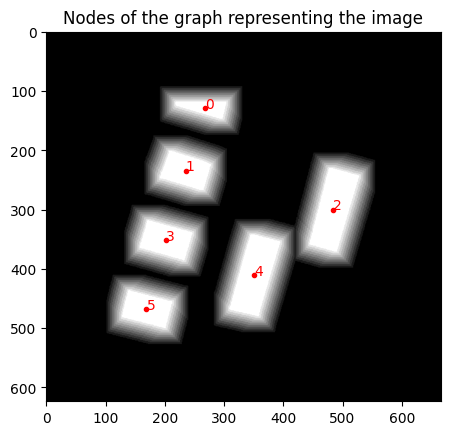

----COMPARE----


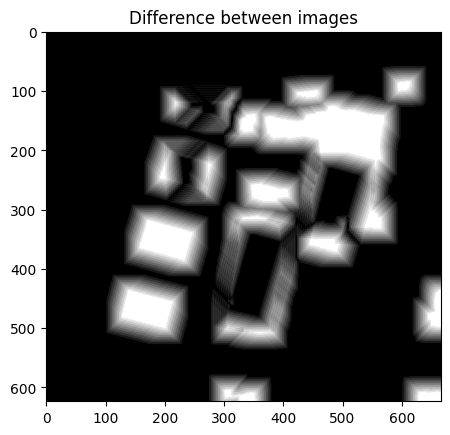

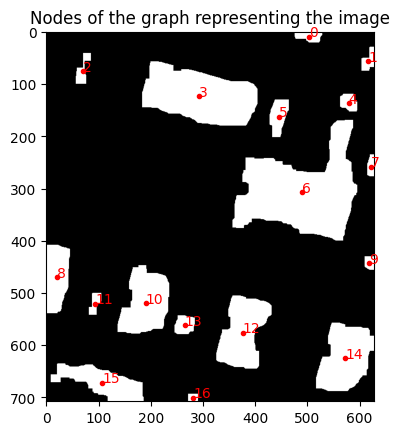

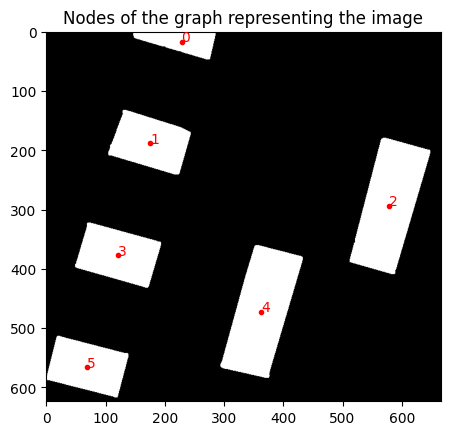

----ROTATION----


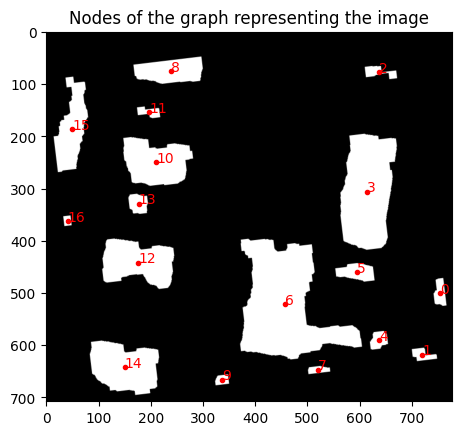

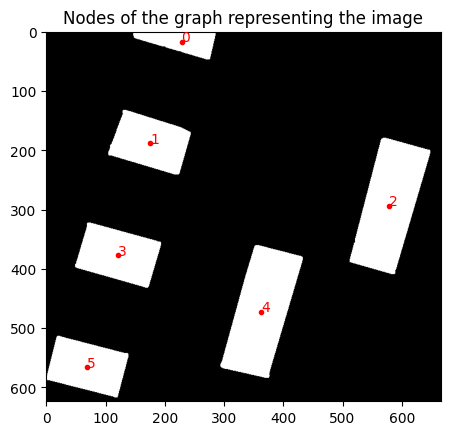

----RESCALE----


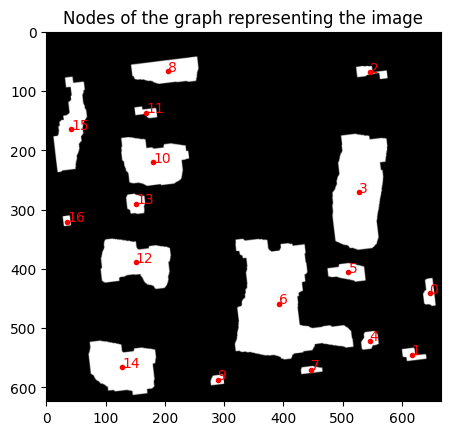

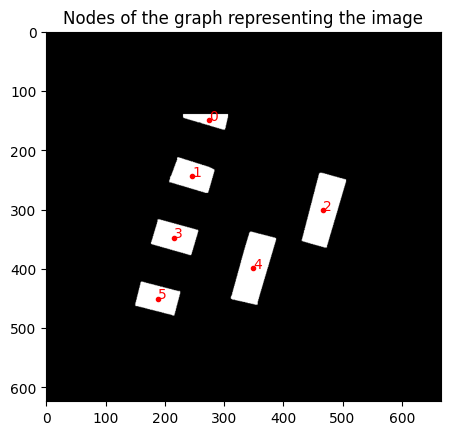

----TRANSLATE----


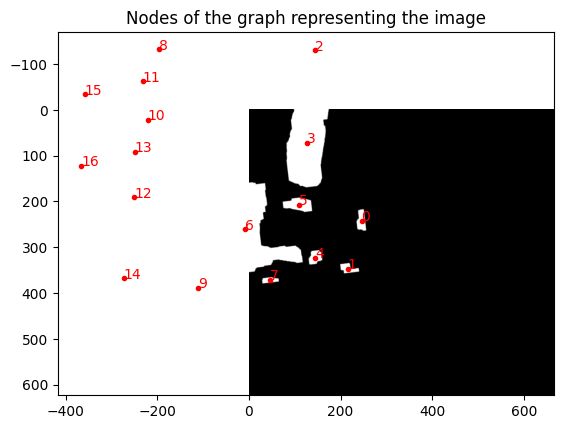

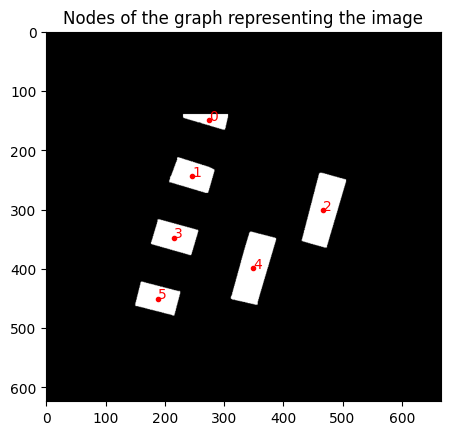

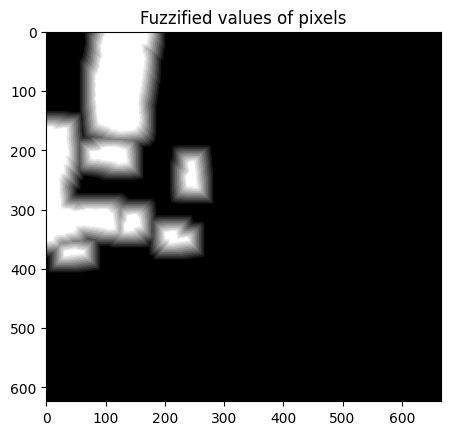

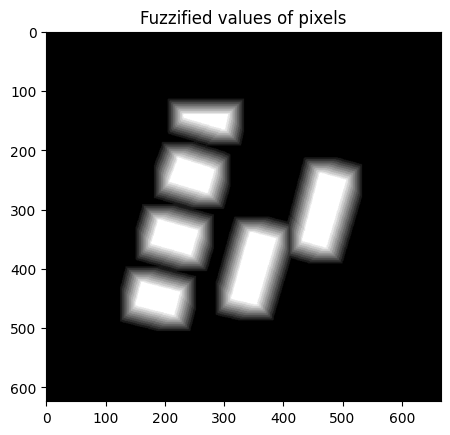

----FUZZIFY----


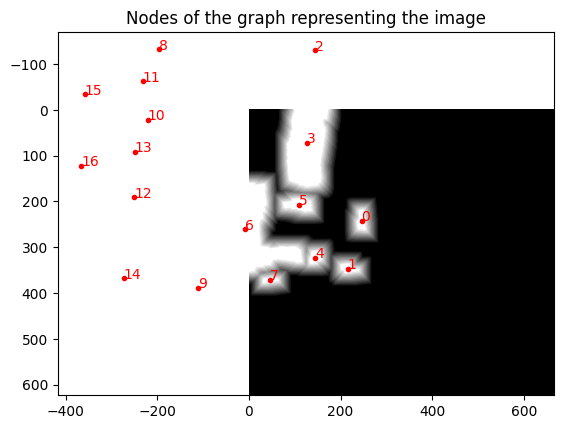

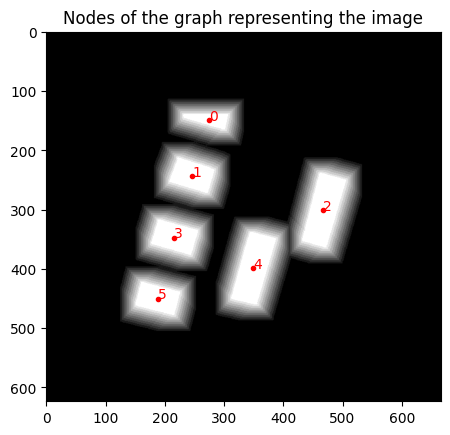

----COMPARE----


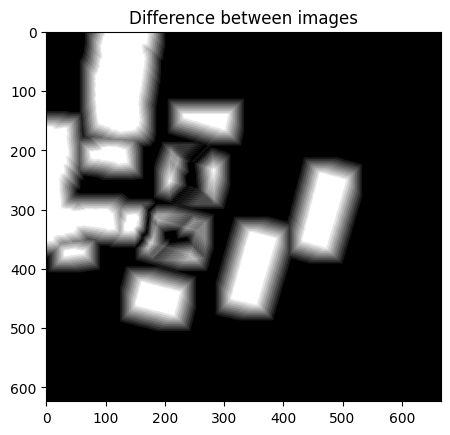

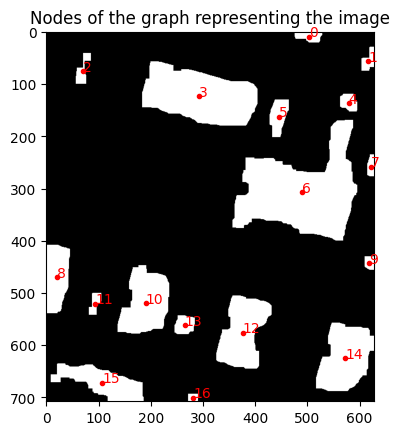

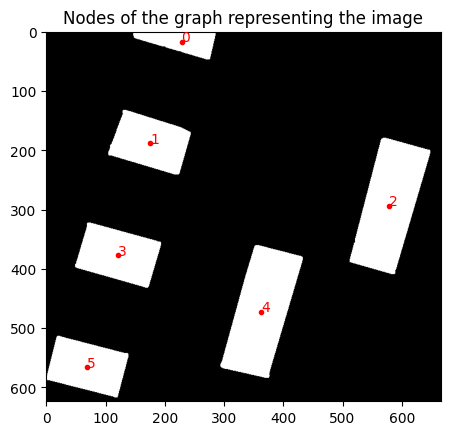

----ROTATION----


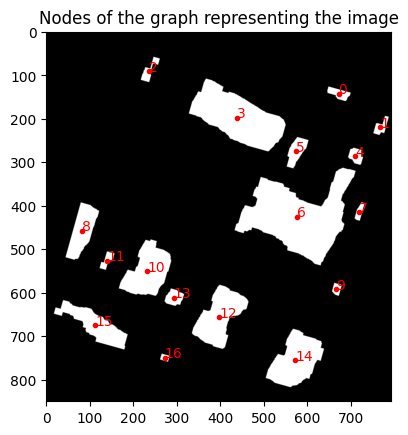

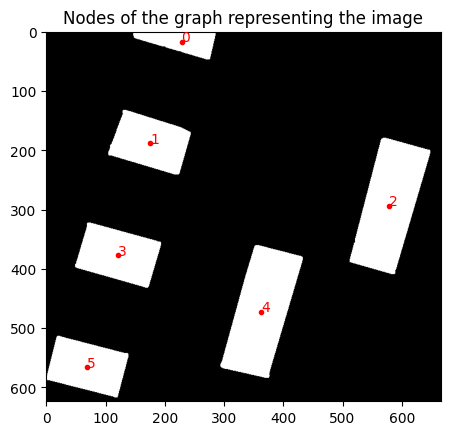

----RESCALE----


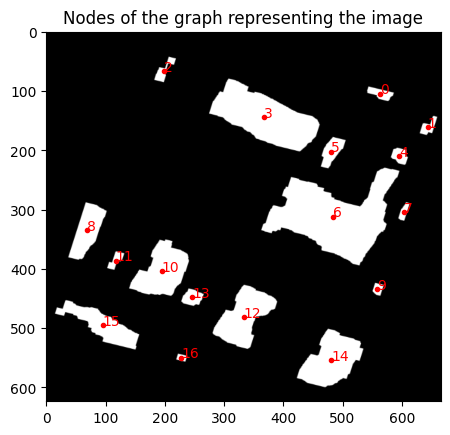

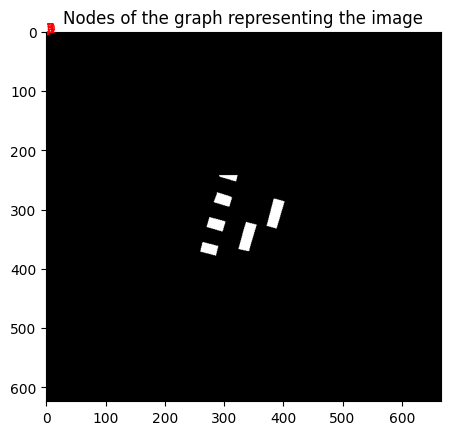

----TRANSLATE----


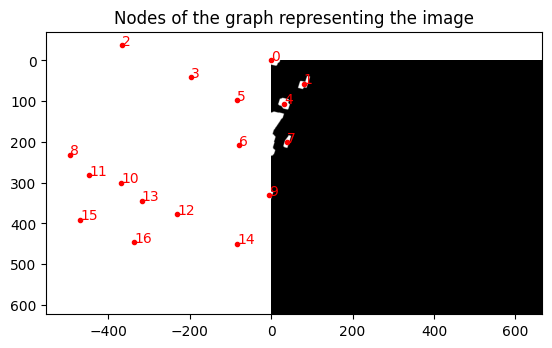

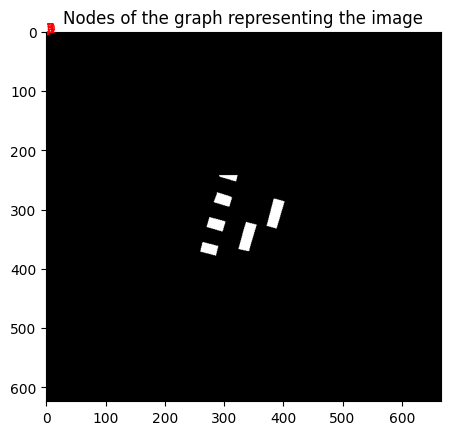

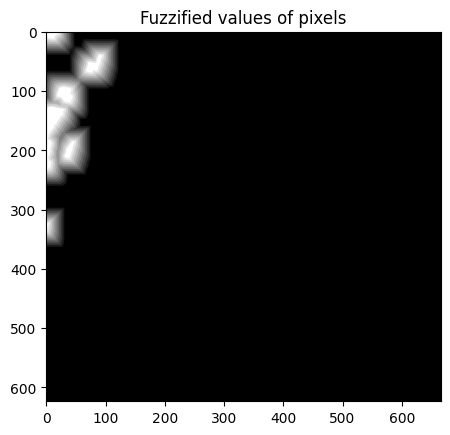

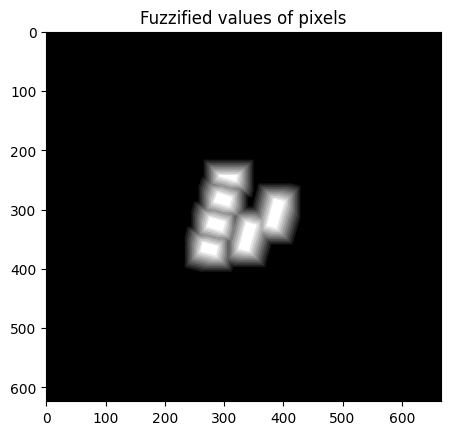

----FUZZIFY----


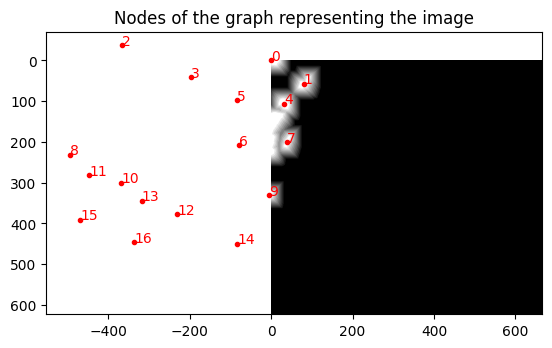

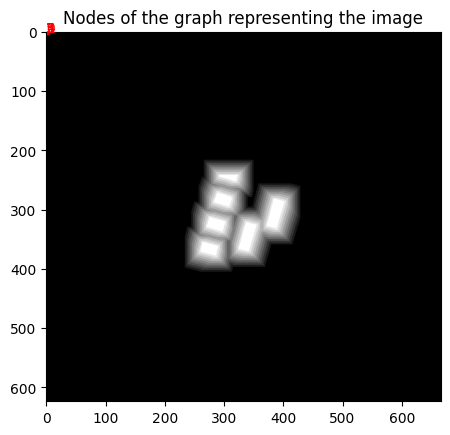

----COMPARE----


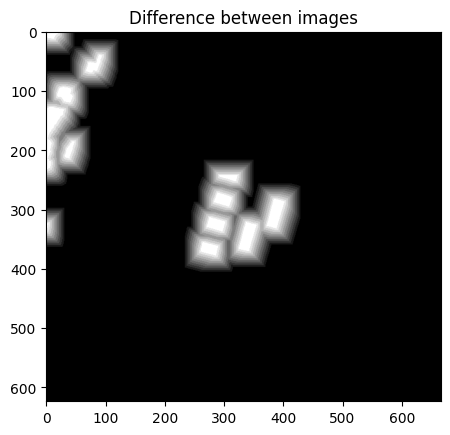

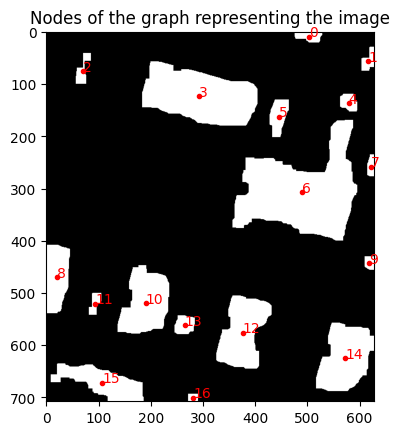

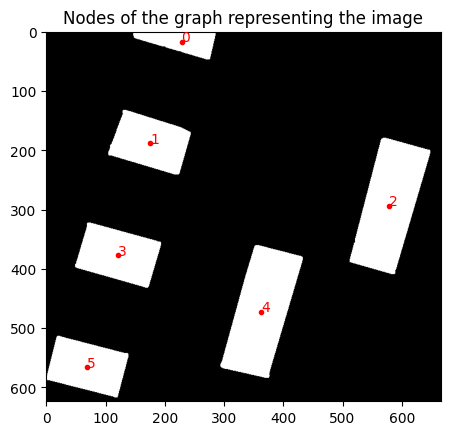

----ROTATION----


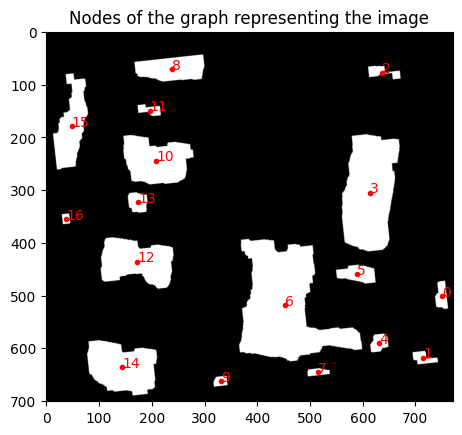

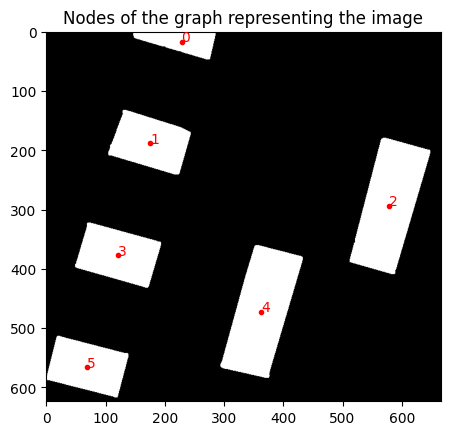

----RESCALE----


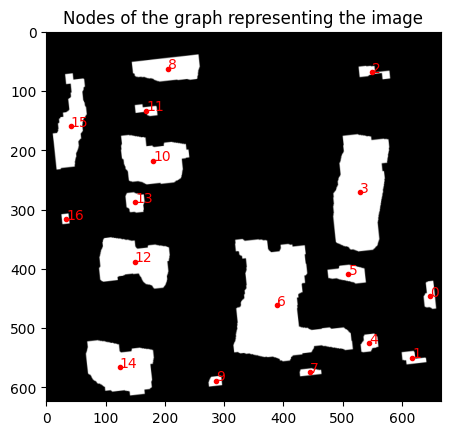

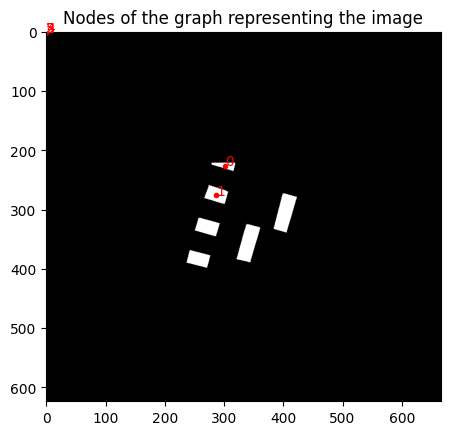

----TRANSLATE----


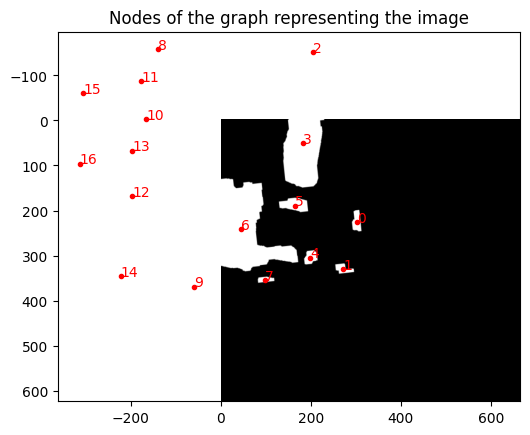

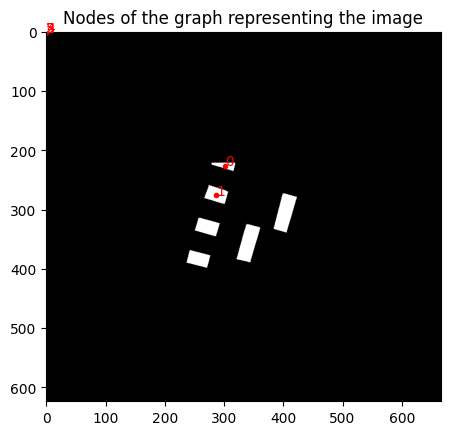

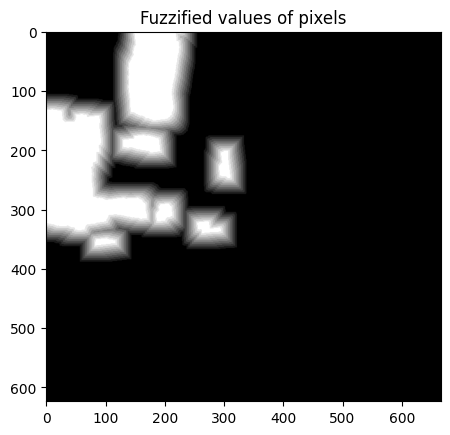

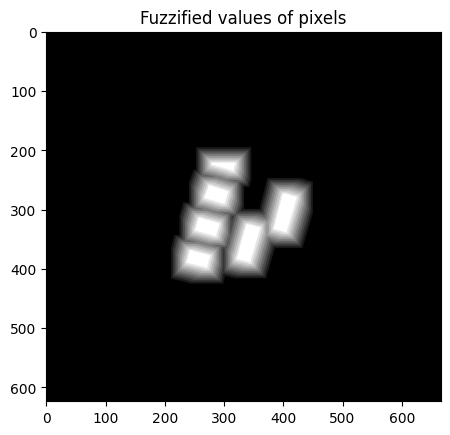

----FUZZIFY----


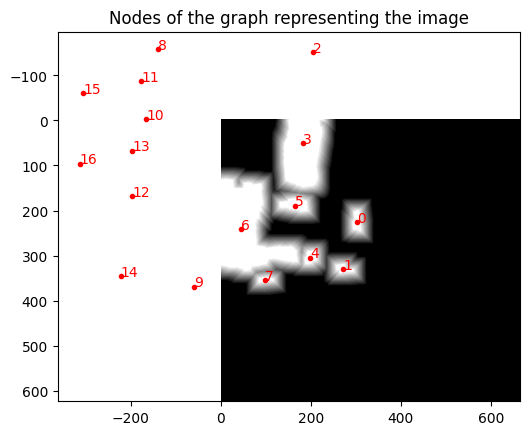

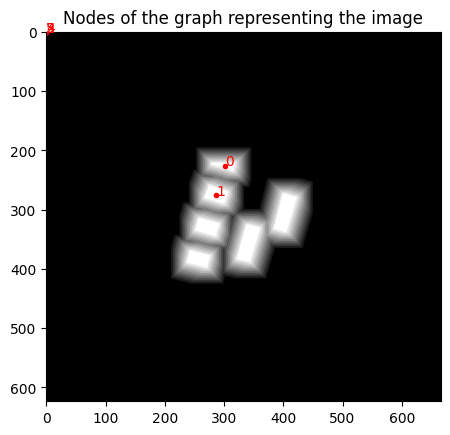

----COMPARE----


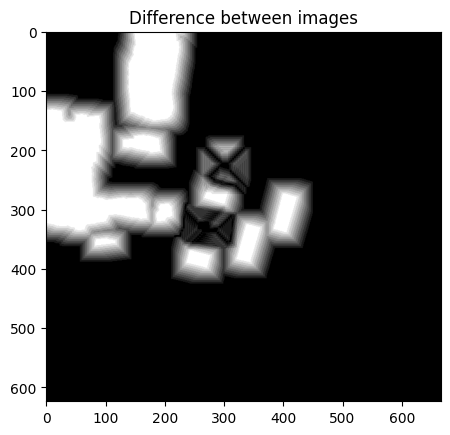

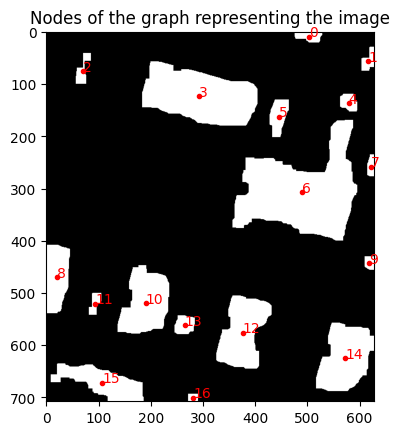

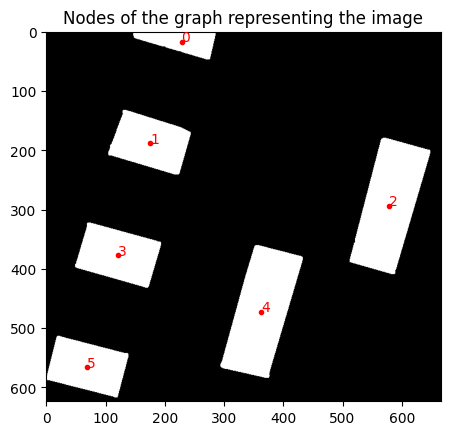

----ROTATION----


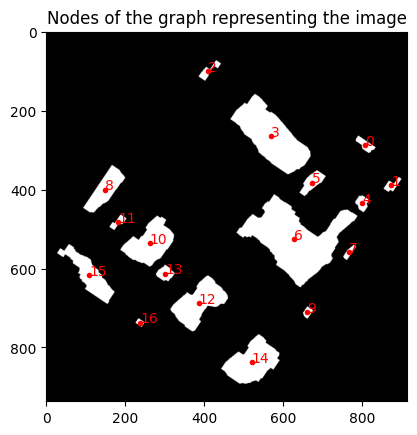

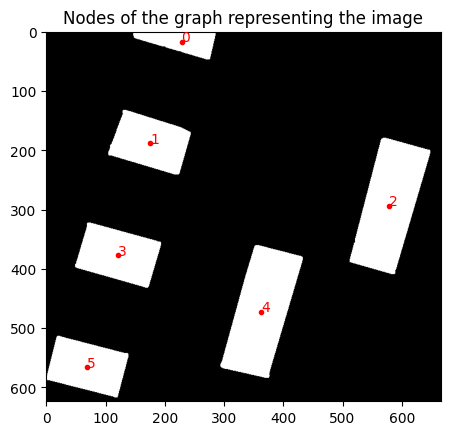

----RESCALE----


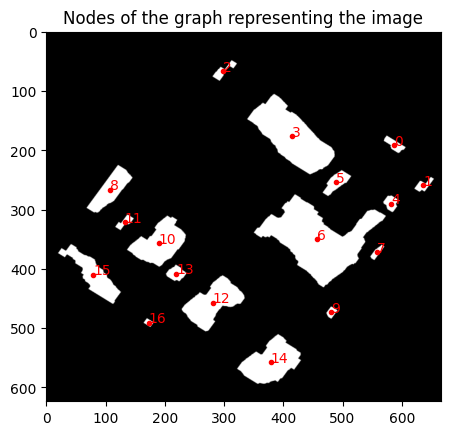

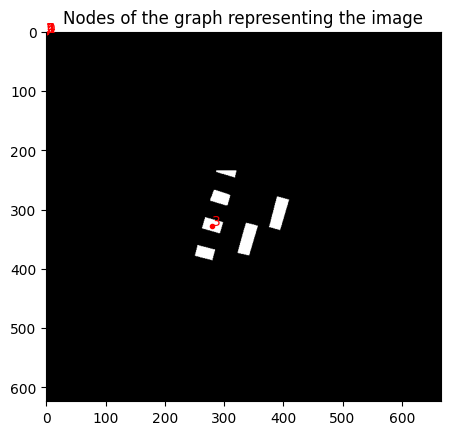

----TRANSLATE----


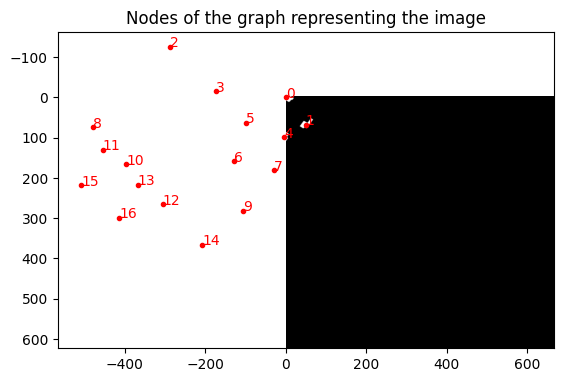

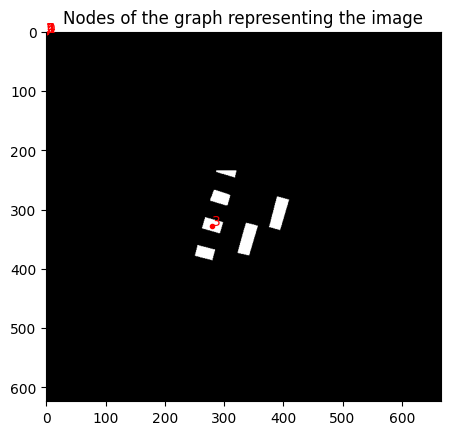

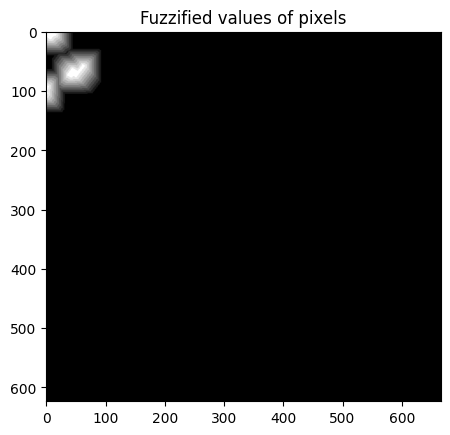

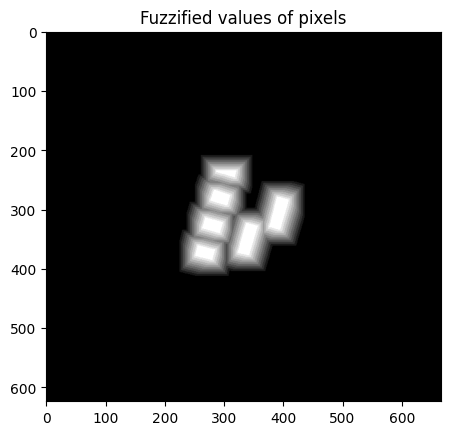

----FUZZIFY----


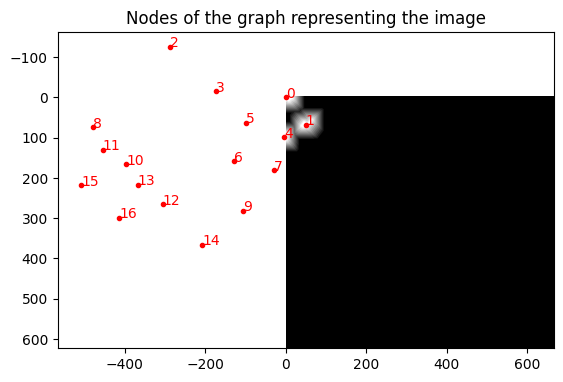

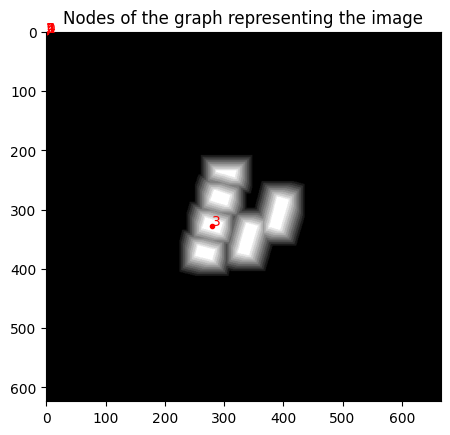

----COMPARE----


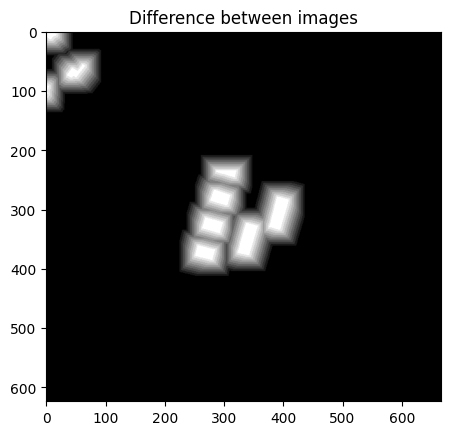

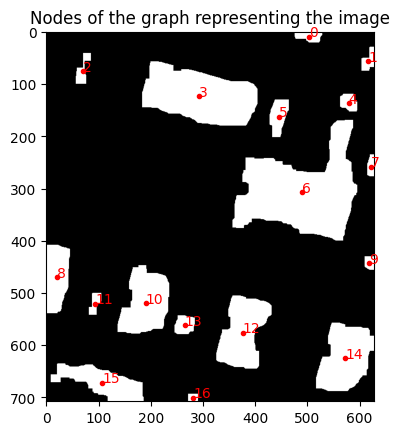

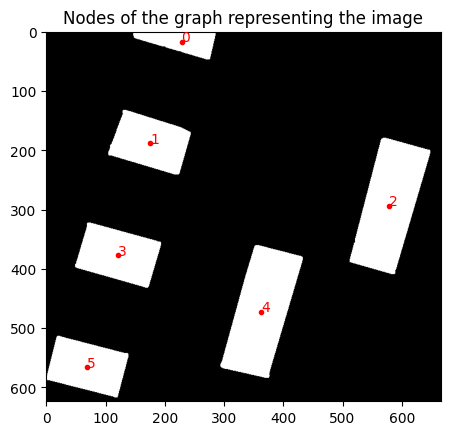

----ROTATION----


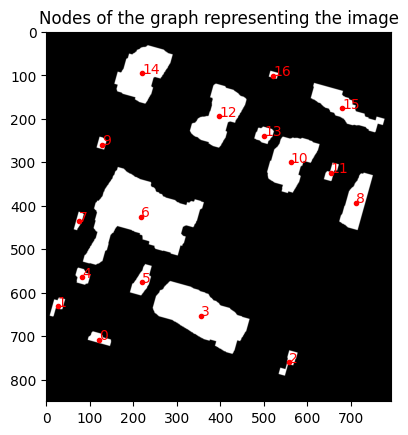

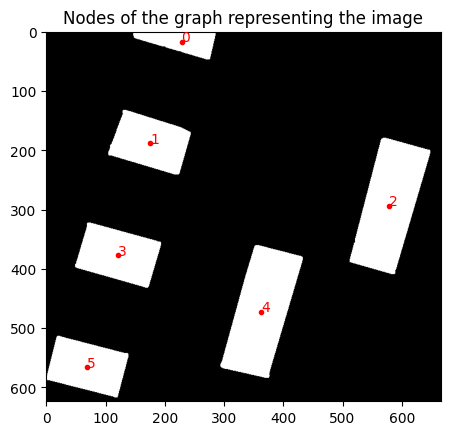

----RESCALE----


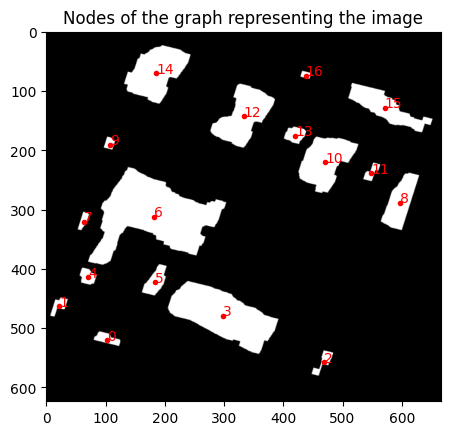

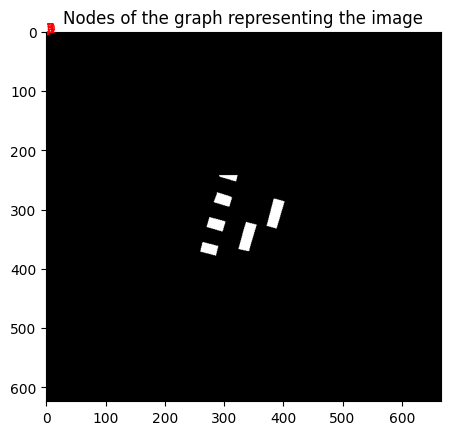

----TRANSLATE----


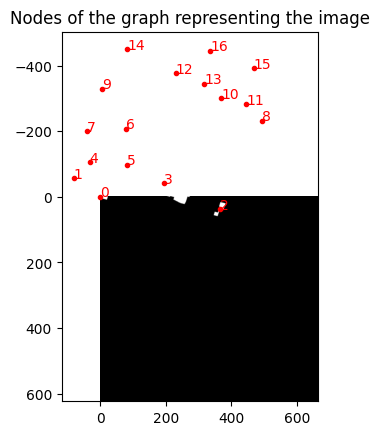

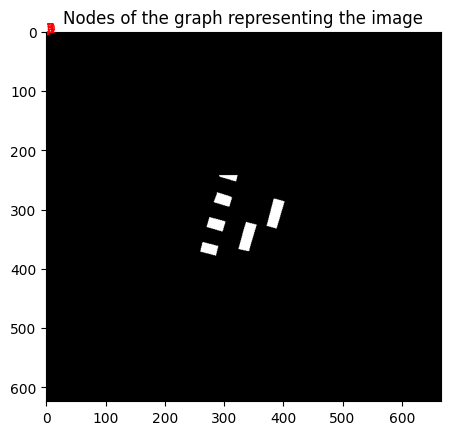

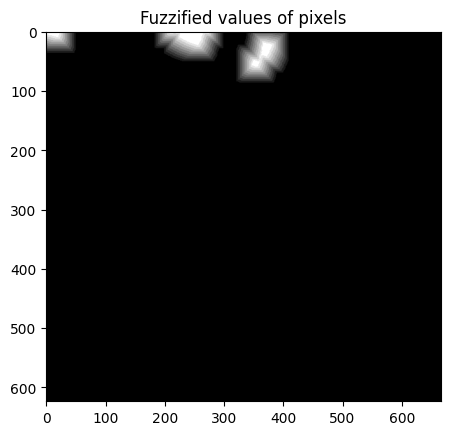

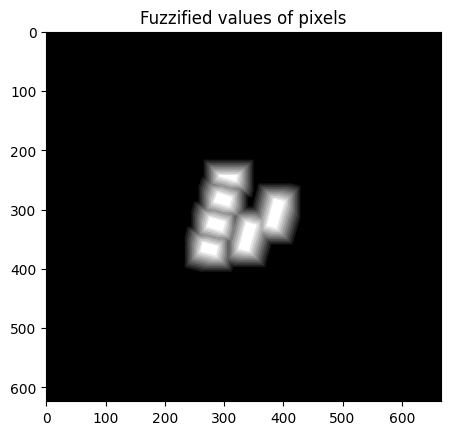

----FUZZIFY----


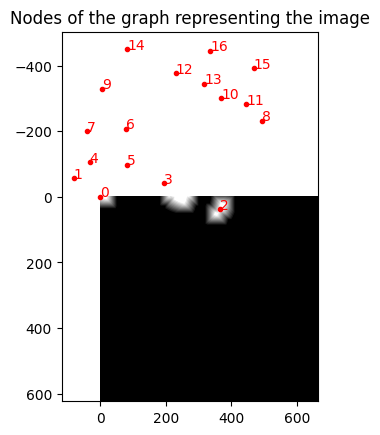

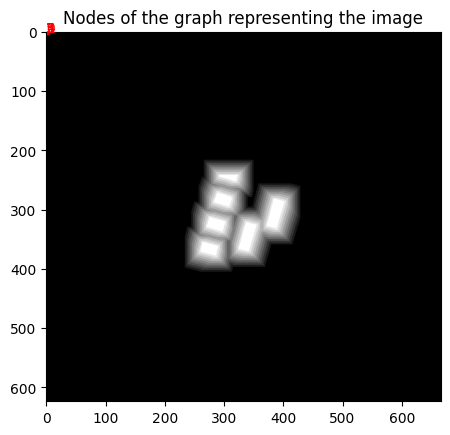

----COMPARE----


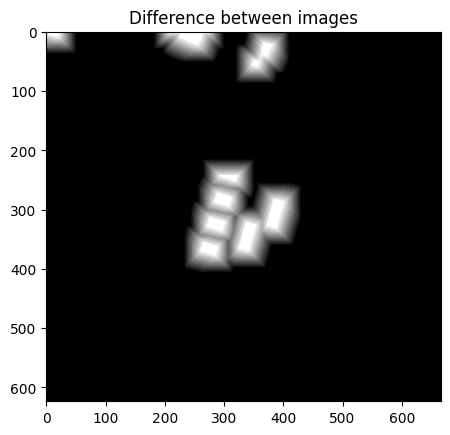

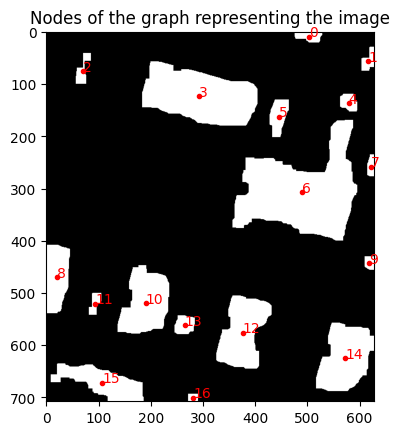

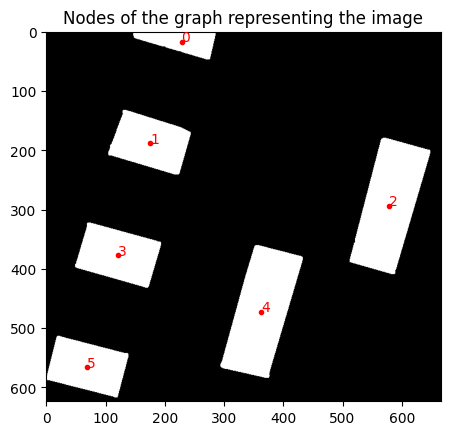

----ROTATION----


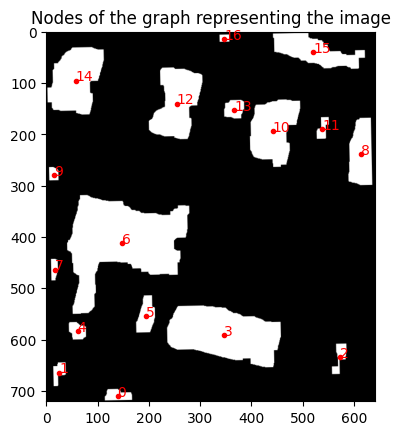

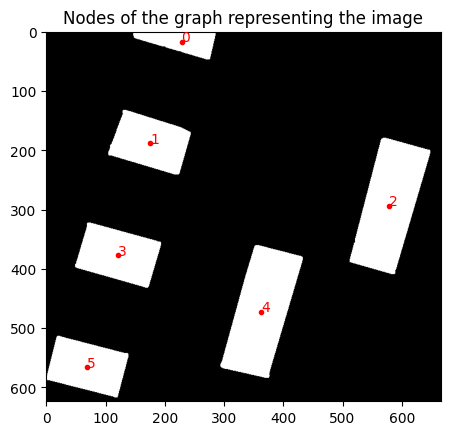

----RESCALE----


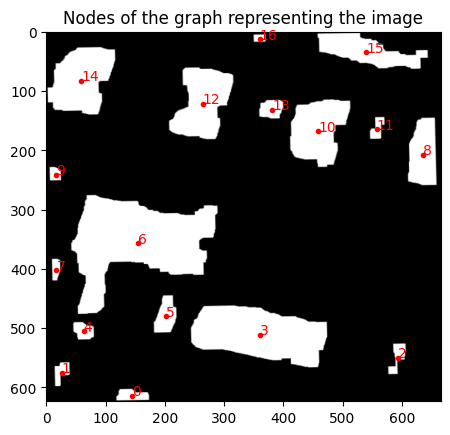

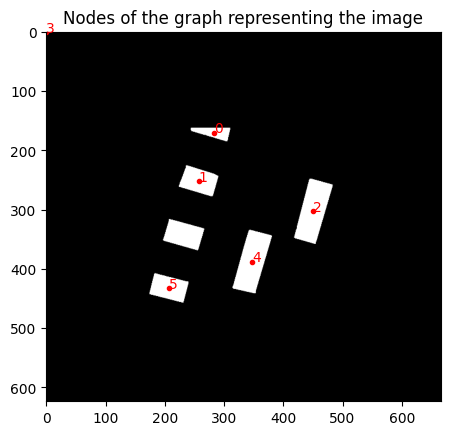

----TRANSLATE----


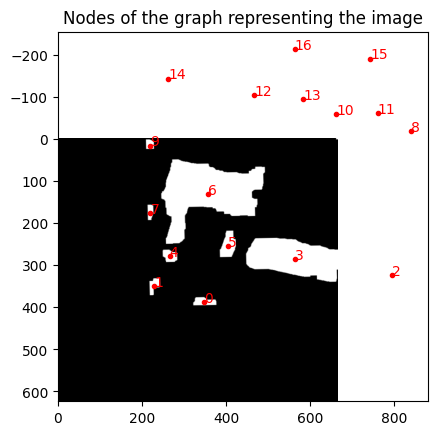

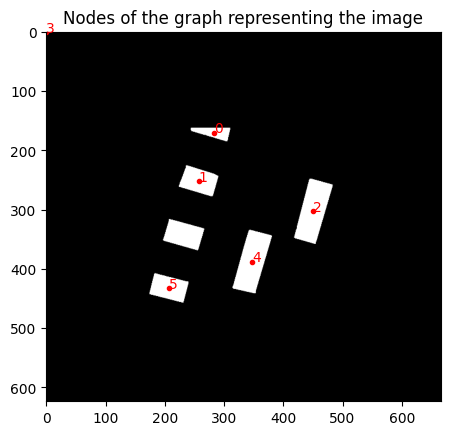

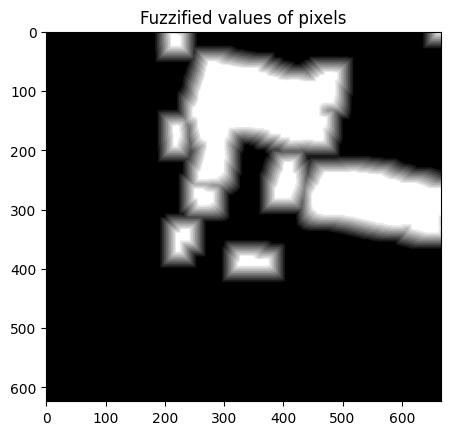

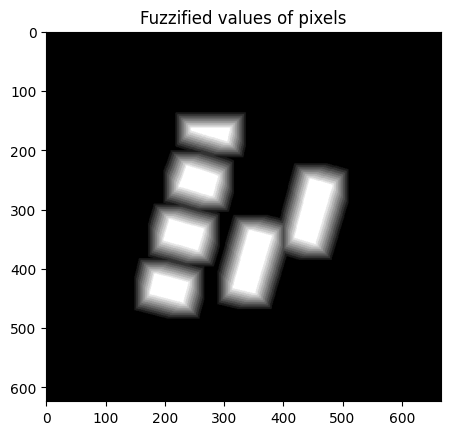

----FUZZIFY----


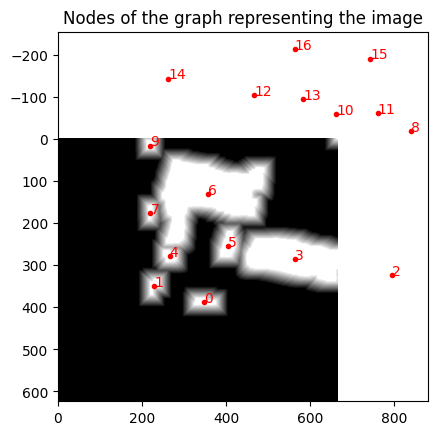

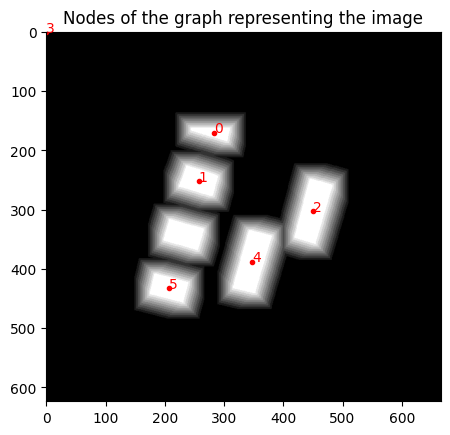

----COMPARE----


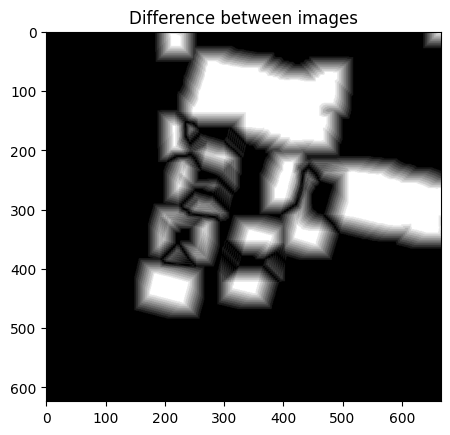

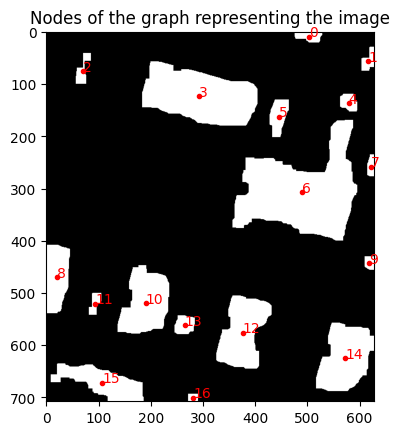

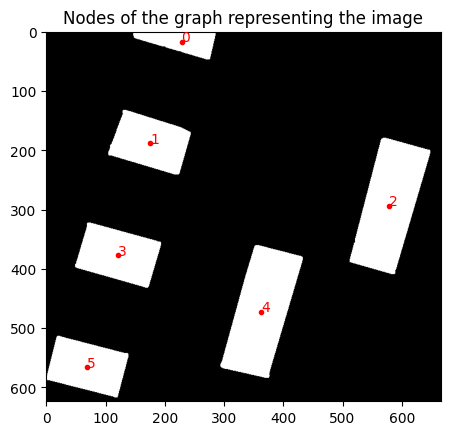

----ROTATION----


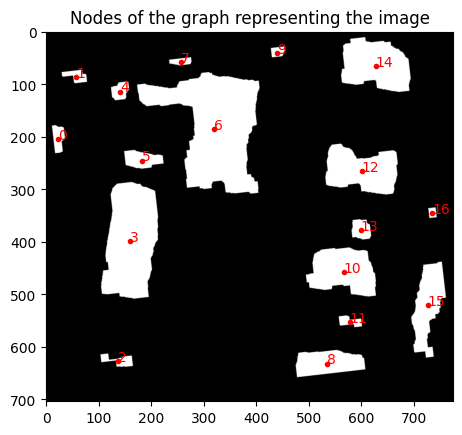

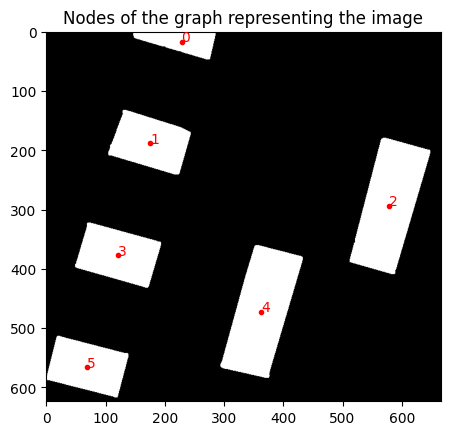

----RESCALE----


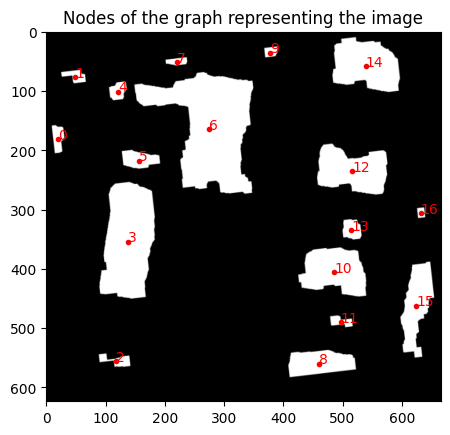

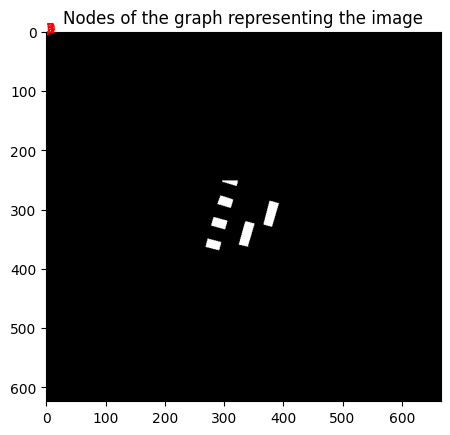

----TRANSLATE----


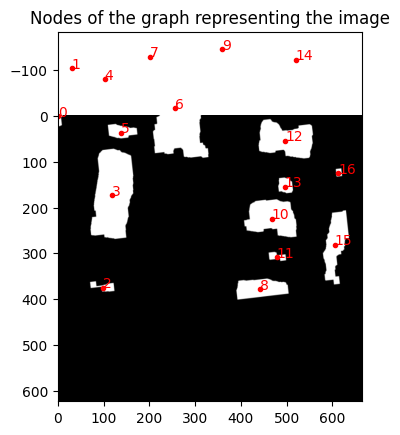

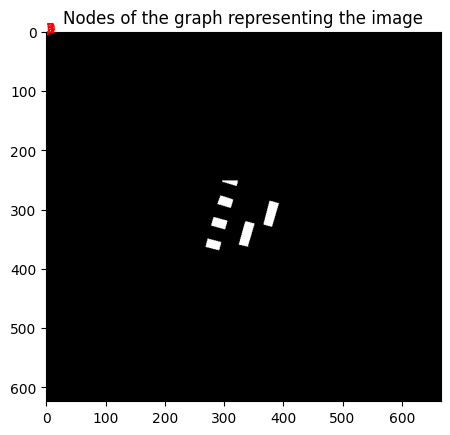

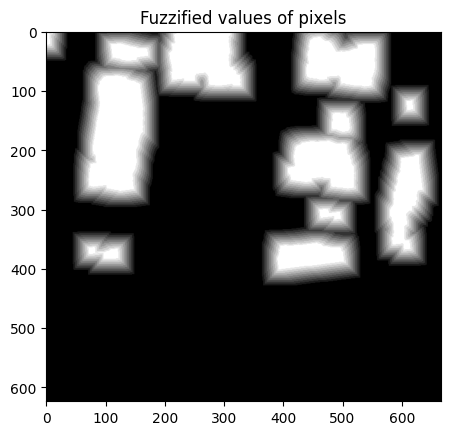

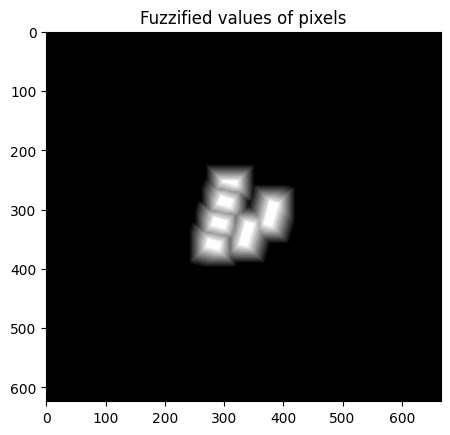

----FUZZIFY----


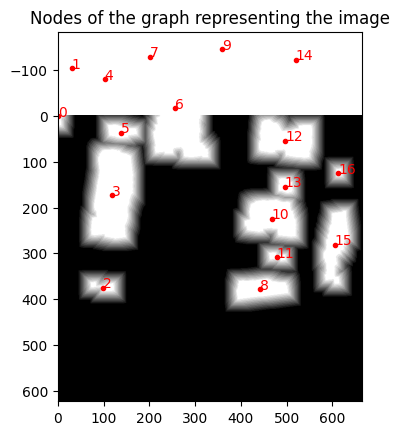

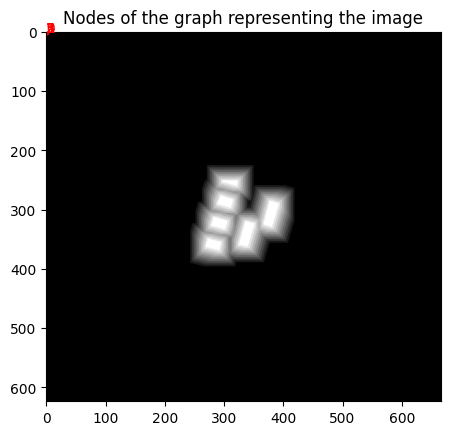

----COMPARE----


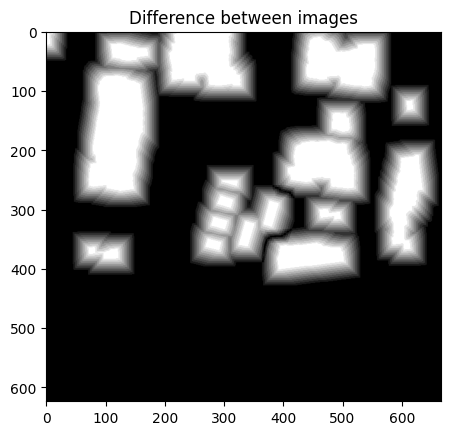

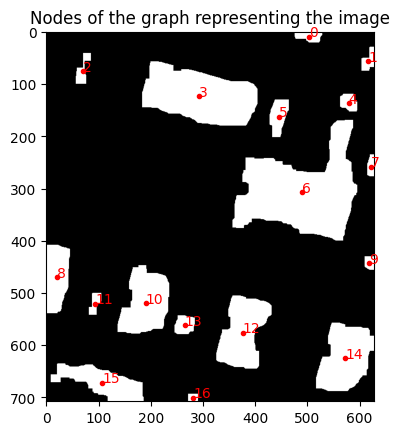

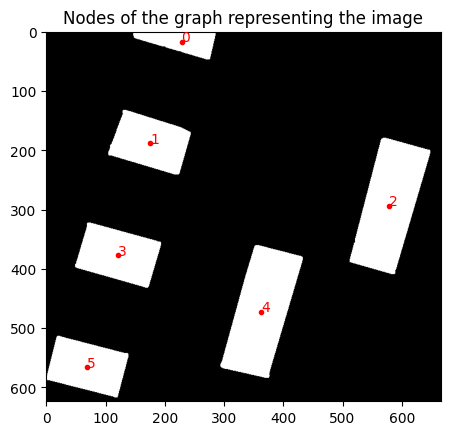

----ROTATION----


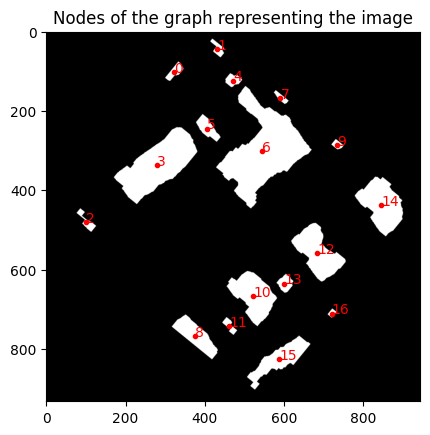

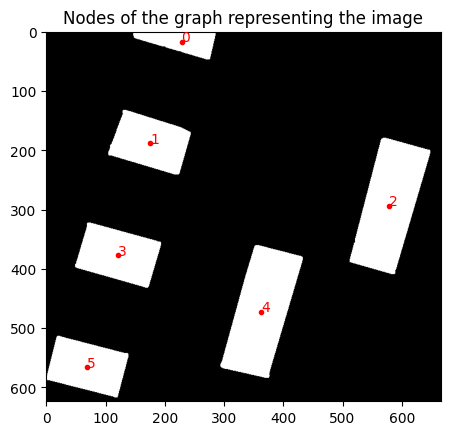

----RESCALE----


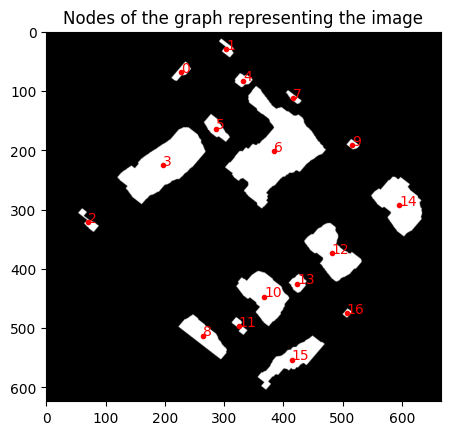

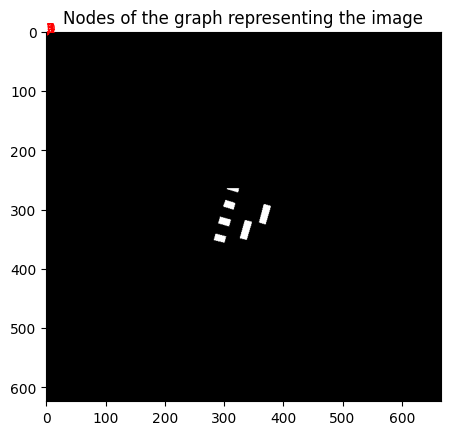

----TRANSLATE----


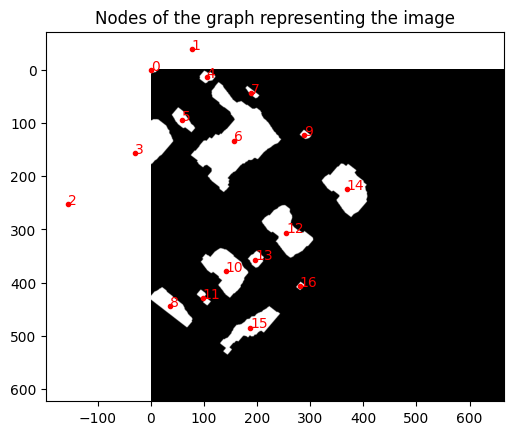

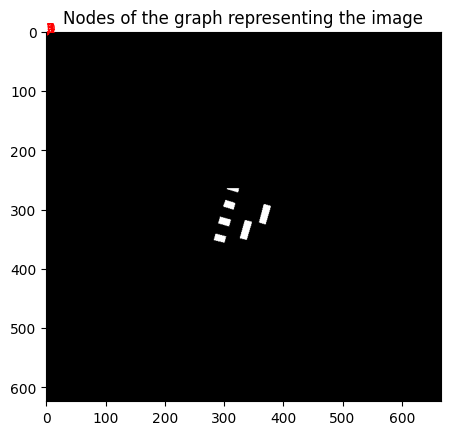

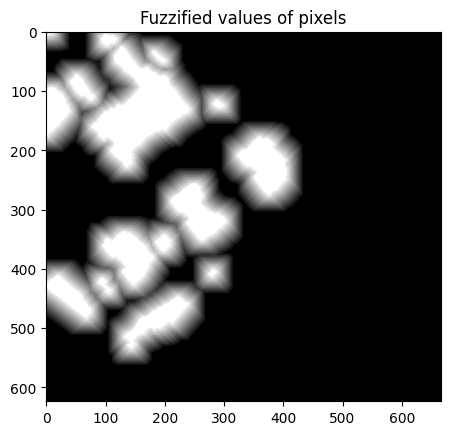

In [ ]:
compare("map1_org.png", "map1_binary_changed.png", plot=True)